In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/grimur/git/nplinker/nplinker/prototype/')


In [3]:
import csv
import numpy

In [4]:
from nplinker import nplinker
from nplinker import logconfig
logconfig.LogConfig.setLogLevel('DEBUG')

from nplinker.parsers.kcb import KCBParser
from nplinker.scoring import misc

['/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/cdk_pywrapper']
Server process already running: True


In [5]:
# Established links

In [6]:
established_links = [
    ('CNS205', 'BGC0000827', 206),
    ('CNS205', 'BGC0000333', 489),
    ('CNB440', 'BGC0000940', 25),
    ('CNB440', 'BGC0000241', 381),
    ('CNT005', 'BGC0001228', 492),
    ('CNS205', 'BGC0000137', 353),
    ('CNS205', 'BGC0000137', 358),
    ('CNS237', 'BGC0001830', 309)
]

In [7]:
# Load data with orignal bigscape weights

In [8]:
npl = nplinker.NPLinker('/home/grimur/data-crusemann/nplinker_crusemann_20200131/crusemann_new.toml')
npl.load_data()

15:01:07 [DEBUG] config.py:72, Parsing default config file: /home/grimur/.config/nplinker/nplinker.toml
15:01:07 [DEBUG] config.py:75, Loading user config /home/grimur/data-crusemann/nplinker_crusemann_20200131/crusemann_new.toml
15:01:07 [INFO] config.py:107, Loading from local data in directory /home/grimur/data-crusemann/nplinker_crusemann_26112019
15:01:07 [DEBUG] loader.py:115, DatasetLoader(/home/grimur/data-crusemann/nplinker_crusemann_26112019, , False)
15:01:07 [DEBUG] nplinker.py:119, Enabled scoring method: metcalf
15:01:07 [DEBUG] nplinker.py:119, Enabled scoring method: testscore
15:01:07 [DEBUG] nplinker.py:119, Enabled scoring method: rosetta
15:01:07 [DEBUG] nplinker.py:240, load_data (normal case, full load, met_only=False)
15:01:07 [WARNING] loader.py:29, WARNING: unable to find extra_nodes_file in path "/home/grimur/data-crusemann/nplinker_crusemann_26112019/quantification_table_reformatted/*.csv"
15:01:07 [WARNING] loader.py:29, WARNING: unable to find metadata_tabl

15:01:08 [WARNING] metabolomics.py:505, Unknown strain: 5a.mzXML for cluster index 116143
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: 6a.mzXML for cluster index 80280
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: 40b.mzXML for cluster index 121459
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: 42b.mzXML for cluster index 95477
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: S801-3-EA.mzXML for cluster index 13340
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: H643-3-EA.mzXML for cluster index 13340
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: 26c.mzXML for cluster index 58621
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: 35c.mzXML for cluster index 58621
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: 28a.mzXML for cluster index 58621
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: 29a.mzXML for cluster index 59110
15:01:08 [WARNING] metabolomics.py:505, Unknown strain: 29c.mzXML for cluster index 5911

True

In [112]:
from nplinker.parsers.kcb import KCBParser

In [137]:
kkb_bgc_hits = {}
for bgc in npl.bgcs:
    kcb_filename = KCBParser.get_kcb_filename_from_bgc(bgc)
    kcb_parser = KCBParser(kcb_filename)
    hits = []
    for mibig_id, hit in kcb_parser.hits.items():
        score = numpy.sum([x['blast_score'] for x in hit['individual_hits']])
        hits.append((mibig_id, score))
    if len(hits) > 0:
        kkb_bgc_hits[bgc] = hits

In [138]:
import csv

In [139]:
gnps_spectrum_file = "/home/grimur/iokr_verify_data/crusemann/extracted/MSV000078836/clusterinfosummarygroup_attributes_withIDs_withcomponentID/b270f7e260f34e808ead3f642784b672.tsv"
spectra_to_strains = {}
with open(gnps_spectrum_file, 'r') as f:
    r = csv.reader(f, delimiter="\t")
    header = next(r)
    id_column = header.index('cluster index')
    strain_columns = [x for x in range(len(header)) if header[x].startswith('C') and len(header[x]) == 6]
    for line in r:
        spectrum_id = line[id_column]
        member_strains = [header[x] for x in range(len(line)) if line[x] != '0' and x in strain_columns]
        spectra_to_strains[int(spectrum_id)] = member_strains

In [140]:
established_link_objects = []
for bgc, kkb_hits in kkb_bgc_hits.items():
    for strain_id, mibig_id, molfam_id in established_links:
        if strain_id == bgc.strain.id or strain_id in bgc.strain.aliases:
            if mibig_id in [x[0] for x in kkb_hits if x[1] > 10000]:
                for molecular_family in npl.molfams:
                    if molecular_family.family_id == molfam_id:
                        for spectrum in molecular_family.spectra:
                            # If we want to do this properly (i.e. using the strain objects on the spectra themselves) then this is broken!
                            if strain_id not in spectra_to_strains[spectrum.spectrum_id]:
                                continue
                            print(strain_id, mibig_id, spectrum.spectrum_id)
                            established_link_objects.append((bgc, spectrum))

CNS205 BGC0000137 72702
CNS205 BGC0000137 72970
CNS205 BGC0000137 73005
CNS205 BGC0000137 70606
CNS205 BGC0000137 75146
CNS205 BGC0000137 75653
CNS205 BGC0000137 72702
CNS205 BGC0000137 72970
CNS205 BGC0000137 73005
CNS205 BGC0000137 70606
CNS205 BGC0000137 75146
CNS205 BGC0000137 75653
CNS205 BGC0000333 120697
CNS205 BGC0000333 121052
CNS205 BGC0000333 121600
CNS205 BGC0000333 122023
CNT005 BGC0001228 123724
CNT005 BGC0001228 123881
CNT005 BGC0001228 123903
CNS205 BGC0000827 41257
CNS205 BGC0000827 41544
CNS205 BGC0000827 44160
CNS205 BGC0000827 44161
CNS205 BGC0000827 44982
CNS237 BGC0001830 58728
CNS237 BGC0001830 62174
CNS237 BGC0001830 63507
CNS237 BGC0001830 63775
CNS237 BGC0001830 65471
CNS237 BGC0001830 66182
CNS237 BGC0001830 66400
CNS237 BGC0001830 67887
CNS237 BGC0001830 68743
CNS237 BGC0001830 93193
CNS237 BGC0001830 99743
CNS237 BGC0001830 100852
CNS237 BGC0001830 101071
CNB440 BGC0000241 77475
CNB440 BGC0000241 84491


In [141]:
verified_bgc_mf_links = []
verified_bgc_mf_links_labels = []
for bgc, kkb_hits in kkb_bgc_hits.items():
    for strain_id, mibig_id, molfam_id in established_links:
        if strain_id == bgc.strain.id or strain_id in bgc.strain.aliases:
            if mibig_id in [x[0] for x in kkb_hits if x[1] > 10000]:
                for molecular_family in npl.molfams:
                    if molecular_family.family_id == molfam_id:
                        verified_bgc_mf_links.append((bgc, molecular_family))
                        verified_bgc_mf_links_labels.append(mibig_id)

In [220]:
verified_gcf_mf_links = []
verified_gcf_mf_links_labels = []
for bgc, kkb_hits in kkb_bgc_hits.items():
    for strain_id, mibig_id, molfam_id in established_links:
        if strain_id == bgc.strain.id or strain_id in bgc.strain.aliases:
            if mibig_id in [x[0] for x in kkb_hits if x[1] > 10000]:
                for molecular_family in npl.molfams:
                    if molecular_family.family_id == molfam_id:
                        for gcf in npl.gcfs:
                            if bgc.id in [x.id for x in gcf.bgcs]:
                                verified_gcf_mf_links.append((gcf, molecular_family))
                                verified_gcf_mf_links_labels.append(mibig_id)

In [152]:
verified_gcf_mf_links

[(GCF(id=71, class=NRPS, gcf_id=980, strains=26),
  <nplinker.metabolomics.MolecularFamily at 0x7fddf46ea588>),
 (GCF(id=333, class=PKS-NRP, gcf_id=863, strains=16),
  <nplinker.metabolomics.MolecularFamily at 0x7fddf46ea588>),
 (GCF(id=71, class=NRPS, gcf_id=980, strains=26),
  <nplinker.metabolomics.MolecularFamily at 0x7fddf46702b0>),
 (GCF(id=333, class=PKS-NRP, gcf_id=863, strains=16),
  <nplinker.metabolomics.MolecularFamily at 0x7fddf46702b0>),
 (GCF(id=48, class=NRPS, gcf_id=767, strains=10),
  <nplinker.metabolomics.MolecularFamily at 0x7fddf46ea588>),
 (GCF(id=123, class=NRPS, gcf_id=2015, strains=2),
  <nplinker.metabolomics.MolecularFamily at 0x7fddf46ea588>),
 (GCF(id=367, class=PKSother, gcf_id=2512, strains=9),
  <nplinker.metabolomics.MolecularFamily at 0x7fddf46ea588>),
 (GCF(id=48, class=NRPS, gcf_id=767, strains=10),
  <nplinker.metabolomics.MolecularFamily at 0x7fddf46702b0>),
 (GCF(id=123, class=NRPS, gcf_id=2015, strains=2),
  <nplinker.metabolomics.MolecularFamil

In [9]:
sal_trop = ['CNB440',
'CNB476',
'CNB536',
'CNH898',
'CNR699',
'CNS197',
'CNS416',
'CNT250',
'CNT261',
'CNY012',
'CNY678',
'CNY681']

In [10]:
sal_are = ['CNB458', 
'CNB527', 
'CNH643', 
'CNH646', 
'CNH713', 
'CNH718', 
'CNH877', 
'CNH905', 
'CNH941', 
'CNH962', 
'CNH963', 
'CNH964', 
'CNH996', 
'CNP105', 
'CNP193', 
'CNQ748', 
'CNQ884', 
'CNR107', 
'CNR425', 
'CNR921', 
'CNS051', 
'CNS205', 
'CNS243', 
'CNS296', 
'CNS299', 
'CNS325', 
'CNS342', 
'CNS673', 
'CNS744', 
'CNS820', 
'CNS848', 
'CNS991', 
'CNT005', 
'CNT088', 
'CNT798', 
'CNT799', 
'CNT800', 
'CNT849', 
'CNT850', 
'CNT857', 
'CNT859', 
'CNX481', 
'CNX482', 
'CNX508', 
'CNX814', 
'CNX891', 
'CNY011', 
'CNY230', 
'CNY231', 
'CNY234', 
'CNY237', 
'CNY244', 
'CNY256', 
'CNY260', 
'CNY280', 
'CNY281', 
'CNY282', 
'CNY486', 
'CNY679', 
'CNY685', 
'CNY690', 
'CNY694']

In [11]:
sal_pac = ['CNH732',
'CNQ768',
'CNR114',
'CNR510',
'CNR894',
'CNR909',
'CNR942',
'CNS055',
'CNS103',
'CNS143',
'CNS237',
'CNS801',
'CNS860',
'CNS863',
'CNS960',
'CNS996',
'CNT001',
'CNT003',
'CNT029',
'CNT045',
'CNT084',
'CNT124',
'CNT131',
'CNT133',
'CNT138',
'CNT148',
'CNT150',
'CNT403',
'CNT569',
'CNT584',
'CNT603',
'CNT609',
'CNT796',
'CNT851',
'CNT854',
'CNT855',
'CNY202',
'CNY239',
'CNY330',
'CNY331',
'CNY363',
'CNY498',
'CNY646',
'CNY666',
'CNY673',
'CNY703']

In [12]:
strep = ['CNB091',
'CNH099',
'CNH189',
'CNH287',
'CNP082',
'CNQ149',
'CNQ329',
'CNQ525',
'CNQ766',
'CNQ865',
'CNR698',
'CNS335',
'CNS606',
'CNS615',
'CNS654',
'CNT302',
'CNT318',
'CNT360',
'CNT371',
'CNT372',
'CNX435',
'CNY228',
'CNY243',
'TAA040',
'TAA204',
'TAA486']

In [13]:
# Only keep the salinispora that we're interested in?
filtered_strains = []
for strain_id in sal_are + sal_pac:
    filtered_strains.append(npl.strains.lookup(strain_id))


In [14]:
npl._strains.filter(filtered_strains)

In [15]:
npl._strains

StrainCollection(n=106)

In [16]:
import numpy
import copy

In [21]:
from Bio import Phylo

In [22]:
import io



In [23]:
with open('/home/grimur/mka_test/data/phylo_tree/Salinispora.tree', 'r') as f:
    salinispora_tree = Phylo.read(f, format='newick')

In [24]:
c = 0
for n in salinispora_tree.get_terminals():
    if n.name.startswith('QS--'):
        n.name = n.name[4:]
    if n.name.endswith('CNS-205'):
        n.name = 'CNS205'
    print(n.name)
    c += 1

CNY260
CNS342
CNT088
CNS744
CNS673
CNY256
CNY234
CNY282
CNY231
CNR921
CNS243
CNY244
CNY237
CNR425
CNQ748
CNS299
CNS325
CNS205
CNT005
CNY230
CNS820
CNR107
CNQ884
CNS296
CNS051
CNH718
CNX481
CNX508
CNX814
CNX482
CNX891
CNT799
CNT850
CNT859
CNT857
CNT800
CNT798
CNT849
CNY280
CNS848
CNS991
CNH964
CNP105
CNP193
CNH941
CNY679
CNH905
CNH877
CNY011
CNH646
CNH713
CNH963
CNH962
CNH996
CNY486
CNB458
CNY690
CNY694
CNB527
CNY685
CNY281
CNS143
CNR510
CNR894
CNS103
CNR909
CNQ768
CNR114
CNT131
CNT603
CNT001
CNS960
CNT003
CNY239
CNH732
CNT855
CNY498
CNY331
CNY330
CNY363
CNT796
CNT851
CNT133
CNT084
CNT609
CNS055
CNT148
CNY666
CNS863
CNS860
CNT403
CNT045
CNS996
CNY703
CNY673
CNT138
CNT029
CNT584
CNT124
CNT854
CNS237
CNT150
CNY646
CNY202
CNR942
CNT569
OG--TS--GCF_900090235--Micromonospora_echinaurantiaca_DSM_43904


In [25]:
Phylo.draw_ascii(salinispora_tree)

                           , CNY260
                           |
                           | CNS342
                           |
                           , CNT088
                           |
                           | CNS744
                           |
                           , CNS673
                           |
                           | CNY256
                           |
                           |, CNY234
                           ,|
                           || CNY282
                           |
                           | CNY231
                           |
                           , CNR921
                           |
                           | CNS243
                           |
                           , CNY244
                           |
                           | CNY237
                           |
                           , CNR425
                           |
                           | CNQ748
                           |
                      

In [26]:
salinispora_tree.prune('OG--TS--GCF_900090235--Micromonospora_echinaurantiaca_DSM_43904')

Clade(confidence=1)

In [27]:
import copy
from nplinker import scoring

In [28]:
### The actual tree stuff

In [97]:
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path[-2]


In [45]:
def set_leaf_properties(leaf_nodes, mf, gcf):
    # overkill
    # mf_ids = set.union(*[x.aliases.union([x.id]) for x in mf.strains])
    # gcf_ids = set.union(*[x.aliases.union([x.id]) for x in gcf.strains])
    mf_ids = [x.id for x in mf.strains]
    gcf_ids = [x.id for x in gcf.strains]
    
    all_ids = []
    
    for leaf in leaf_nodes:
        strain_id = leaf.name
        all_ids.append(strain_id)
        
        if strain_id in mf_ids:
            in_mf = True
        else:
            in_mf = False
        
        if strain_id in gcf_ids:
            in_gcf = True
        else:
            in_gcf = False
            
        leaf.properties = (in_mf, in_gcf)
        
    return leaf_nodes

In [46]:
def collapse_tree_(tree, collapse_type):
    leaves = tree.get_terminals()
    nodes_to_check = list(leaves)
    # print(len(nodes_to_check))

    mock_node_counter = 0  # Keep track of mocked nodes
    while len(nodes_to_check) != 0:
        node = nodes_to_check.pop(0)
        # print('Checking node', node)
        # print('Terminal nodes:', tree.get_terminals())
        # Loop through to look for potential siblings
        for potential_sibling_node in tree.get_terminals():
            # print('+', node, potential_sibling_node)
            dist = tree.trace(node, potential_sibling_node)
            # siblings are terminal nodes with dist. exactly two
            if len(dist) == 2:
                # print(node, potential_sibling_node)
                if potential_sibling_node in nodes_to_check:
                    # print(nodes_to_check)
                    sibling_idx = nodes_to_check.index(potential_sibling_node)
                    sibling_node = nodes_to_check.pop(sibling_idx)
                sibling_node = potential_sibling_node
                # print('break')
                break
        else:
            # print('No sibling for', node)
            continue
        # Phylo.draw_ascii(tree)
        # print(node, node.properties, sibling_node, sibling_node.properties)

        # Check if properties match
        if node.properties == sibling_node.properties:# and node.properties == (True, True):
            if collapse_type != 'all' and node.properties != (True, True):
                continue
            #print('merge', node.properties)
            mock_node_counter += 1
            
            # print('total size:', len(tree.get_terminals()))
            # print(tree.get_terminals())

            mock_node = get_parent(tree, node)
            mock_node_id = "mock{}".format(mock_node_counter)
            mock_node_properties = node.properties

            mock_node.clades = []
            mock_node.name = mock_node_id
            mock_node.properties = mock_node_properties

            leaves = tree.get_terminals()
            if sibling_node in nodes_to_check:
                nodes_to_check.remove(sibling_node)
            nodes_to_check.append(mock_node)
            
            if len(leaves) <= 2:
                break
            
        # nodes_to_check = list(set(tree.get_terminals()).intersection(nodes_to_check))

    return tree

In [47]:
def calculate_correlation(orig_tree, mf, gcf, collapse='all'):
    # Copy the tree
    tree = copy.deepcopy(orig_tree)  # Does this work??
    leaves = tree.get_terminals()
    
    # Set the leaf nodes to indicate mf/gcf presence (node.data['status'])
    leaves = set_leaf_properties(leaves, mf, gcf)
    
    # Collapse nodes with identical status
    if collapse:
        tree = collapse_tree_(tree, collapse)

    leaf_nodes = tree.get_terminals()
    
    #print('{} -> {} nodes'.format(len(leaves), len(leaf_nodes)))
    
    # Standardised correlation score
    population_size = len(leaf_nodes)
    mf_size = len([x for x in leaf_nodes if x.properties[0] is True])
    gcf_size = len([x for x in leaf_nodes if x.properties[1] is True])
    overlap = len([x for x in leaf_nodes if x.properties == (True, True)])
        
    # Score weights
    w_neither, w_gcf_only, w_mf_only, w_both = scoring.misc.METCALF_WEIGHTS
    
    raw_score = scoring.misc.metcalf_count(mf_size, 
                                           gcf_size, 
                                           overlap, 
                                           population_size, 
                                           w_both, 
                                           w_mf_only, 
                                           w_gcf_only, 
                                           w_neither)
    
    score_exp, score_var = scoring.misc.metcalf_expected_count(mf_size, 
                                                               gcf_size, 
                                                               overlap, 
                                                               population_size, 
                                                               w_both, 
                                                               w_mf_only, 
                                                               w_gcf_only, 
                                                               w_neither)
    
    return (raw_score - score_exp) / numpy.sqrt(score_var)

In [48]:
len(npl.strains._strains)

106

In [55]:
import time

def calc_all_pairs(tree, gcfs, mfs, strain_list):
    score_collection = {}
    count = 0
    gcf_strains = []
    mf_strains = []
    
    print('precomputing strain lists')
    for gcf in gcfs:
        gcf_strain_list = []
        for x in gcf.strains:
            try: 
                gcf_strain_list.append(strain_list.index(x))
            except ValueError:
                pass
        gcf_strains.append(gcf_strain_list)
    for mf in mfs:
        mf_strain_list = []
        for x in mf.strains:
            try:
                mf_strain_list.append(strain_list.index(x))
            except ValueError:
                pass
        mf_strains.append(mf_strain_list)
    
    t0 = time.time()
    print('calculating correlation')
    for gcf_idx, gcf in enumerate(gcfs):
        count += 1
        subcount = 0
        for mf_idx, mf in enumerate(mfs):
            subcount += 1

            if subcount % 100 == 0:
                print("{}/{}, {}/{}".format(count, len(gcfs), subcount, len(mfs)))
                t1 = time.time()
                print(t1 - t0)
                t0 = t1

            #gcf_strain_list = str(list(gcf.strains))
            #mf_strain_list = str(list(mf.strains))
            gcf_strain_list = tuple(gcf_strains[gcf_idx])
            mf_strain_list = tuple(mf_strains[mf_idx])
            
            #print(gcf_strain_list)
            #print(mf_strain_list)
            
            if (mf_strain_list, gcf_strain_list) not in score_collection:
                phylo_score = calculate_correlation(tree, mf, gcf, collapse='all')
                score_collection[(mf_strain_list, gcf_strain_list)] = phylo_score
                
    return score_collection


CNY260
Clade


14

Clade(branch_length=0.00117788, name='CNY260')

In [98]:
res = calc_all_pairs(salinispora_tree, npl.gcfs, npl.molfams, npl.strains._strains)

precomputing strain lists
calculating corrleation
1/454, 100/3094
21.141782999038696
1/454, 200/3094
14.951650857925415
1/454, 300/3094
16.999765872955322
1/454, 400/3094
13.305462837219238
1/454, 500/3094
10.549993991851807
1/454, 600/3094
13.181974172592163
1/454, 700/3094
10.551456451416016
1/454, 800/3094
11.709800004959106
1/454, 900/3094
10.304381847381592
1/454, 1000/3094
9.053613901138306
1/454, 1100/3094
10.182235956192017
1/454, 1200/3094
7.241164684295654
1/454, 1300/3094
9.306440830230713
1/454, 1400/3094
9.221521854400635
1/454, 1500/3094
9.059094667434692
1/454, 1600/3094
12.790526866912842
1/454, 1700/3094
7.349402189254761
1/454, 1800/3094
9.345736265182495
1/454, 1900/3094
9.070616960525513
1/454, 2000/3094
8.698957443237305
1/454, 2100/3094
9.615311622619629
1/454, 2200/3094
12.04952335357666
1/454, 2300/3094
11.448152542114258
1/454, 2400/3094
10.623668432235718
1/454, 2500/3094
7.702982664108276
1/454, 2600/3094
6.5918145179748535
1/454, 2700/3094
2.5645172595977783

8/454, 2400/3094
9.744603395462036
8/454, 2500/3094
7.102123975753784
8/454, 2600/3094
6.096358060836792
8/454, 2700/3094
2.31121826171875
8/454, 2800/3094
9.240314960479736
8/454, 2900/3094
7.328836441040039
8/454, 3000/3094
5.129028797149658
9/454, 100/3094
3.394885301589966
9/454, 200/3094
0.00012803077697753906
9/454, 300/3094
0.00020575523376464844
9/454, 400/3094
0.00011110305786132812
9/454, 500/3094
6.341934204101562e-05
9/454, 600/3094
6.937980651855469e-05
9/454, 700/3094
6.246566772460938e-05
9/454, 800/3094
6.4849853515625e-05
9/454, 900/3094
6.246566772460938e-05
9/454, 1000/3094
0.000125885009765625
9/454, 1100/3094
6.341934204101562e-05
9/454, 1200/3094
5.936622619628906e-05
9/454, 1300/3094
5.936622619628906e-05
9/454, 1400/3094
6.103515625e-05
9/454, 1500/3094
6.747245788574219e-05
9/454, 1600/3094
6.29425048828125e-05
9/454, 1700/3094
5.8650970458984375e-05
9/454, 1800/3094
6.198883056640625e-05
9/454, 1900/3094
5.9604644775390625e-05
9/454, 2000/3094
5.69820404052734

18/454, 100/3094
20.753893613815308
18/454, 200/3094
14.487751245498657
18/454, 300/3094
16.462849617004395
18/454, 400/3094
12.751983642578125
18/454, 500/3094
10.183850765228271
18/454, 600/3094
12.77517056465149
18/454, 700/3094
10.22104263305664
18/454, 800/3094
11.45189094543457
18/454, 900/3094
9.898533821105957
18/454, 1000/3094
8.792232036590576
18/454, 1100/3094
9.85080862045288
18/454, 1200/3094
6.976538419723511
18/454, 1300/3094
8.921434164047241
18/454, 1400/3094
8.981889486312866
18/454, 1500/3094
8.632085084915161
18/454, 1600/3094
12.371877193450928
18/454, 1700/3094
7.091720104217529
18/454, 1800/3094
9.022890090942383
18/454, 1900/3094
8.627013683319092
18/454, 2000/3094
8.496208667755127
18/454, 2100/3094
9.349488258361816
18/454, 2200/3094
11.574565410614014
18/454, 2300/3094
10.965251922607422
18/454, 2400/3094
10.247557640075684
18/454, 2500/3094
7.470061302185059
18/454, 2600/3094
6.404546499252319
18/454, 2700/3094
2.4458200931549072
18/454, 2800/3094
9.70587158

25/454, 1300/3094
13.745302438735962
25/454, 1400/3094
12.91595983505249
25/454, 1500/3094
13.235252857208252
25/454, 1600/3094
18.50561022758484
25/454, 1700/3094
10.99919056892395
25/454, 1800/3094
13.072301149368286
25/454, 1900/3094
13.481668710708618
25/454, 2000/3094
12.414057493209839
25/454, 2100/3094
13.893378019332886
25/454, 2200/3094
17.488012075424194
25/454, 2300/3094
16.789119482040405
25/454, 2400/3094
14.90617060661316
25/454, 2500/3094
11.017929792404175
25/454, 2600/3094
9.433105707168579
25/454, 2700/3094
3.6680614948272705
25/454, 2800/3094
14.499452114105225
25/454, 2900/3094
10.77330231666565
25/454, 3000/3094
7.959834814071655
26/454, 100/3094
31.70354390144348
26/454, 200/3094
18.69674825668335
26/454, 300/3094
21.580688953399658
26/454, 400/3094
17.15617799758911
26/454, 500/3094
13.428751945495605
26/454, 600/3094
17.011411905288696
26/454, 700/3094
13.08444094657898
26/454, 800/3094
14.832424640655518
26/454, 900/3094
13.382895708084106
26/454, 1000/3094
11.

33/454, 100/3094
21.783841371536255
33/454, 200/3094
15.425124645233154
33/454, 300/3094
17.38877296447754
33/454, 400/3094
13.597682476043701
33/454, 500/3094
10.767398834228516
33/454, 600/3094
13.511154890060425
33/454, 700/3094
10.833826541900635
33/454, 800/3094
12.022690534591675
33/454, 900/3094
10.508619546890259
33/454, 1000/3094
9.328301191329956
33/454, 1100/3094
10.501317501068115
33/454, 1200/3094
7.46856164932251
33/454, 1300/3094
9.53952431678772
33/454, 1400/3094
9.523001670837402
33/454, 1500/3094
9.252528190612793
33/454, 1600/3094
13.11636996269226
33/454, 1700/3094
7.450624704360962
33/454, 1800/3094
9.707714557647705
33/454, 1900/3094
9.239467144012451
33/454, 2000/3094
8.962802410125732
33/454, 2100/3094
9.929914474487305
33/454, 2200/3094
12.363176107406616
33/454, 2300/3094
11.60367751121521
33/454, 2400/3094
10.936573505401611
33/454, 2500/3094
7.962056875228882
33/454, 2600/3094
6.786580324172974
33/454, 2700/3094
2.6493122577667236
33/454, 2800/3094
10.382714

46/454, 100/3094
20.31278896331787
46/454, 200/3094
14.384467124938965
46/454, 300/3094
15.980095863342285
46/454, 400/3094
12.524606466293335
46/454, 500/3094
9.920908451080322
46/454, 600/3094
12.522347211837769
46/454, 700/3094
10.049387454986572
46/454, 800/3094
11.16036343574524
46/454, 900/3094
9.633341550827026
46/454, 1000/3094
8.680870532989502
46/454, 1100/3094
9.685618162155151
46/454, 1200/3094
6.958988904953003
46/454, 1300/3094
8.727739334106445
46/454, 1400/3094
8.780924081802368
46/454, 1500/3094
8.438804388046265
46/454, 1600/3094
12.10305666923523
46/454, 1700/3094
6.8823864459991455
46/454, 1800/3094
8.892467021942139
46/454, 1900/3094
8.482518196105957
46/454, 2000/3094
8.323351383209229
46/454, 2100/3094
9.049780368804932
46/454, 2200/3094
11.383944988250732
46/454, 2300/3094
10.689327716827393
46/454, 2400/3094
10.000346422195435
46/454, 2500/3094
7.381741046905518
46/454, 2600/3094
6.227386713027954
46/454, 2700/3094
2.4607484340667725
46/454, 2800/3094
9.5298950

54/454, 100/3094
22.192869901657104
54/454, 200/3094
15.763592004776001
54/454, 300/3094
17.977347135543823
54/454, 400/3094
14.059615850448608
54/454, 500/3094
11.134066104888916
54/454, 600/3094
13.909450054168701
54/454, 700/3094
11.10525631904602
54/454, 800/3094
12.40439486503601
54/454, 900/3094
10.982291221618652
54/454, 1000/3094
9.509591817855835
54/454, 1100/3094
10.67983627319336
54/454, 1200/3094
7.6594438552856445
54/454, 1300/3094
9.829292297363281
54/454, 1400/3094
9.806936264038086
54/454, 1500/3094
9.496898651123047
54/454, 1600/3094
13.55264687538147
54/454, 1700/3094
7.910250663757324
54/454, 1800/3094
9.79524040222168
54/454, 1900/3094
9.493472337722778
54/454, 2000/3094
9.298048734664917
54/454, 2100/3094
10.205652952194214
54/454, 2200/3094
12.864392042160034
54/454, 2300/3094
12.123511552810669
54/454, 2400/3094
11.322839975357056
54/454, 2500/3094
8.110340356826782
54/454, 2600/3094
6.988351345062256
54/454, 2700/3094
2.716557741165161
54/454, 2800/3094
10.60825

71/454, 100/3094
25.81189751625061
71/454, 200/3094
18.122051239013672
71/454, 300/3094
20.87629461288452
71/454, 400/3094
16.45620632171631
71/454, 500/3094
13.049023389816284
71/454, 600/3094
16.139743089675903
71/454, 700/3094
12.889556169509888
71/454, 800/3094
14.141404628753662
71/454, 900/3094
12.684840202331543
71/454, 1000/3094
10.936479806900024
71/454, 1100/3094
12.405170202255249
71/454, 1200/3094
8.877390146255493
71/454, 1300/3094
11.514036417007446
71/454, 1400/3094
11.172144174575806
71/454, 1500/3094
11.185194253921509
71/454, 1600/3094
15.667683601379395
71/454, 1700/3094
9.261279582977295
71/454, 1800/3094
11.320244073867798
71/454, 1900/3094
11.117990016937256
71/454, 2000/3094
10.527431011199951
71/454, 2100/3094
11.743135929107666
71/454, 2200/3094
14.561042070388794
71/454, 2300/3094
14.128917694091797
71/454, 2400/3094
12.666461944580078
71/454, 2500/3094
9.25042986869812
71/454, 2600/3094
7.827082633972168
71/454, 2700/3094
3.1264684200286865
71/454, 2800/3094


80/454, 100/3094
19.606229066848755
80/454, 200/3094
13.893975973129272
80/454, 300/3094
15.439828634262085
80/454, 400/3094
12.066278219223022
80/454, 500/3094
9.642508506774902
80/454, 600/3094
12.094461679458618
80/454, 700/3094
9.63506007194519
80/454, 800/3094
10.889320373535156
80/454, 900/3094
9.347947597503662
80/454, 1000/3094
8.421919822692871
80/454, 1100/3094
9.350478649139404
80/454, 1200/3094
6.706807374954224
80/454, 1300/3094
8.435127258300781
80/454, 1400/3094
8.628292560577393
80/454, 1500/3094
8.223837614059448
80/454, 1600/3094
11.72347092628479
80/454, 1700/3094
6.697714328765869
80/454, 1800/3094
8.555214166641235
80/454, 1900/3094
8.156301259994507
80/454, 2000/3094
7.979064226150513
80/454, 2100/3094
8.766771078109741
80/454, 2200/3094
10.862109661102295
80/454, 2300/3094
10.31791877746582
80/454, 2400/3094
9.69422960281372
80/454, 2500/3094
7.033804893493652
80/454, 2600/3094
6.0216217041015625
80/454, 2700/3094
2.322404146194458
80/454, 2800/3094
9.20962476730

87/454, 1700/3094
6.633749961853027
87/454, 1800/3094
8.597851753234863
87/454, 1900/3094
8.18897533416748
87/454, 2000/3094
8.053247451782227
87/454, 2100/3094
8.756017446517944
87/454, 2200/3094
10.86717414855957
87/454, 2300/3094
10.329954147338867
87/454, 2400/3094
9.660522222518921
87/454, 2500/3094
7.067777395248413
87/454, 2600/3094
6.0458409786224365
87/454, 2700/3094
2.315824508666992
87/454, 2800/3094
9.18685531616211
87/454, 2900/3094
7.2189671993255615
87/454, 3000/3094
5.112539291381836
88/454, 100/3094
22.89130449295044
88/454, 200/3094
13.858718156814575
88/454, 300/3094
15.372085094451904
88/454, 400/3094
11.993297576904297
88/454, 500/3094
9.572028636932373
88/454, 600/3094
12.00600790977478
88/454, 700/3094
9.713021278381348
88/454, 800/3094
10.845206260681152
88/454, 900/3094
9.322140455245972
88/454, 1000/3094
8.389851093292236
88/454, 1100/3094
9.292022943496704
88/454, 1200/3094
6.69474458694458
88/454, 1300/3094
8.453198432922363
88/454, 1400/3094
8.5531928539276

94/454, 2600/3094
6.146792888641357
94/454, 2700/3094
2.34149432182312
94/454, 2800/3094
9.306551933288574
94/454, 2900/3094
7.36890172958374
94/454, 3000/3094
5.2194859981536865
95/454, 100/3094
24.919686317443848
95/454, 200/3094
15.191621780395508
95/454, 300/3094
17.039519786834717
95/454, 400/3094
13.370418787002563
95/454, 500/3094
10.621797561645508
95/454, 600/3094
13.38865852355957
95/454, 700/3094
10.707814455032349
95/454, 800/3094
11.909548997879028
95/454, 900/3094
10.498013734817505
95/454, 1000/3094
9.19995927810669
95/454, 1100/3094
10.291723012924194
95/454, 1200/3094
7.38079309463501
95/454, 1300/3094
9.379895687103271
95/454, 1400/3094
9.358270168304443
95/454, 1500/3094
9.085172653198242
95/454, 1600/3094
12.991580486297607
95/454, 1700/3094
7.378660440444946
95/454, 1800/3094
9.380238771438599
95/454, 1900/3094
9.155591249465942
95/454, 2000/3094
8.724756002426147
95/454, 2100/3094
9.643847465515137
95/454, 2200/3094
12.132420063018799
95/454, 2300/3094
11.47931003

102/454, 1200/3094
7.297335624694824
102/454, 1300/3094
9.303905010223389
102/454, 1400/3094
9.358628273010254
102/454, 1500/3094
9.098487138748169
102/454, 1600/3094
12.877892017364502
102/454, 1700/3094
7.440384149551392
102/454, 1800/3094
9.430655717849731
102/454, 1900/3094
9.048128366470337
102/454, 2000/3094
8.863400936126709
102/454, 2100/3094
9.694950819015503
102/454, 2200/3094
12.205798864364624
102/454, 2300/3094
11.462561130523682
102/454, 2400/3094
10.774409294128418
102/454, 2500/3094
7.7912516593933105
102/454, 2600/3094
6.689587831497192
102/454, 2700/3094
2.5609490871429443
102/454, 2800/3094
10.157301187515259
102/454, 2900/3094
8.02376127243042
102/454, 3000/3094
5.672995328903198
103/454, 100/3094
3.774829626083374
103/454, 200/3094
0.00012540817260742188
103/454, 300/3094
0.00021958351135253906
103/454, 400/3094
9.131431579589844e-05
103/454, 500/3094
7.05718994140625e-05
103/454, 600/3094
6.67572021484375e-05
103/454, 700/3094
6.580352783203125e-05
103/454, 800/30

109/454, 1900/3094
8.199387550354004
109/454, 2000/3094
7.968404054641724
109/454, 2100/3094
8.705884456634521
109/454, 2200/3094
10.912091732025146
109/454, 2300/3094
10.284610986709595
109/454, 2400/3094
9.674396753311157
109/454, 2500/3094
7.0481297969818115
109/454, 2600/3094
6.01186728477478
109/454, 2700/3094
2.2899038791656494
109/454, 2800/3094
9.16036319732666
109/454, 2900/3094
7.283661842346191
109/454, 3000/3094
5.140943765640259
110/454, 100/3094
23.194554328918457
110/454, 200/3094
14.197079420089722
110/454, 300/3094
15.795414447784424
110/454, 400/3094
12.34028172492981
110/454, 500/3094
9.805379867553711
110/454, 600/3094
12.411176443099976
110/454, 700/3094
9.921287059783936
110/454, 800/3094
11.026479482650757
110/454, 900/3094
9.597200155258179
110/454, 1000/3094
8.59122371673584
110/454, 1100/3094
9.50492262840271
110/454, 1200/3094
6.890628099441528
110/454, 1300/3094
8.614412307739258
110/454, 1400/3094
8.728141784667969
110/454, 1500/3094
8.430177927017212
110/4

116/454, 2800/3094
9.221098899841309
116/454, 2900/3094
7.3447840213775635
116/454, 3000/3094
5.129622936248779
117/454, 100/3094
23.584387063980103
117/454, 200/3094
14.40592622756958
117/454, 300/3094
16.131381511688232
117/454, 400/3094
12.63598108291626
117/454, 500/3094
10.02867603302002
117/454, 600/3094
12.549391746520996
117/454, 700/3094
10.078030347824097
117/454, 800/3094
11.283109426498413
117/454, 900/3094
9.885327816009521
117/454, 1000/3094
8.601761817932129
117/454, 1100/3094
9.702343702316284
117/454, 1200/3094
6.957992792129517
117/454, 1300/3094
8.870388984680176
117/454, 1400/3094
8.798336505889893
117/454, 1500/3094
8.606229543685913
117/454, 1600/3094
12.239025831222534
117/454, 1700/3094
6.979464054107666
117/454, 1800/3094
8.939366340637207
117/454, 1900/3094
8.575254917144775
117/454, 2000/3094
8.352801084518433
117/454, 2100/3094
9.147685289382935
117/454, 2200/3094
11.46448278427124
117/454, 2300/3094
10.770112037658691
117/454, 2400/3094
10.094315528869629
1

124/454, 800/3094
11.786418199539185
124/454, 900/3094
10.450162649154663
124/454, 1000/3094
9.111440658569336
124/454, 1100/3094
10.202709674835205
124/454, 1200/3094
7.310213565826416
124/454, 1300/3094
9.324340343475342
124/454, 1400/3094
9.259677171707153
124/454, 1500/3094
9.048763275146484
124/454, 1600/3094
13.022717714309692
124/454, 1700/3094
7.411269664764404
124/454, 1800/3094
9.37662410736084
124/454, 1900/3094
9.209713697433472
124/454, 2000/3094
8.797181844711304
124/454, 2100/3094
9.71311640739441
124/454, 2200/3094
12.030059099197388
124/454, 2300/3094
11.472254037857056
124/454, 2400/3094
10.602745294570923
124/454, 2500/3094
7.807293176651001
124/454, 2600/3094
6.687964677810669
124/454, 2700/3094
2.629765510559082
124/454, 2800/3094
10.023966789245605
124/454, 2900/3094
7.854534864425659
124/454, 3000/3094
5.6141626834869385
125/454, 100/3094
27.35800814628601
125/454, 200/3094
16.759003162384033
125/454, 300/3094
19.062194347381592
125/454, 400/3094
15.0379648208618

131/454, 1700/3094
8.41838788986206
131/454, 1800/3094
10.346285343170166
131/454, 1900/3094
10.370822191238403
131/454, 2000/3094
9.86658239364624
131/454, 2100/3094
10.890180110931396
131/454, 2200/3094
13.719642877578735
131/454, 2300/3094
12.916915655136108
131/454, 2400/3094
11.981821775436401
131/454, 2500/3094
8.703113317489624
131/454, 2600/3094
7.447580575942993
131/454, 2700/3094
2.9203498363494873
131/454, 2800/3094
11.314881086349487
131/454, 2900/3094
8.584074258804321
131/454, 3000/3094
6.274296522140503
132/454, 100/3094
26.425076007843018
132/454, 200/3094
15.742152690887451
132/454, 300/3094
17.685715198516846
132/454, 400/3094
14.030269145965576
132/454, 500/3094
10.953200340270996
132/454, 600/3094
14.024988412857056
132/454, 700/3094
10.941856622695923
132/454, 800/3094
12.38429069519043
132/454, 900/3094
10.98355746269226
132/454, 1000/3094
9.517951726913452
132/454, 1100/3094
10.64573860168457
132/454, 1200/3094
7.580821752548218
132/454, 1300/3094
9.7659659385681

138/454, 2000/3094
9.268296718597412
138/454, 2100/3094
10.167940139770508
138/454, 2200/3094
12.446522235870361
138/454, 2300/3094
12.26282286643982
138/454, 2400/3094
10.923884868621826
138/454, 2500/3094
8.067756175994873
138/454, 2600/3094
6.882870435714722
138/454, 2700/3094
2.721034526824951
138/454, 2800/3094
10.860474348068237
138/454, 2900/3094
8.273231029510498
138/454, 3000/3094
5.8759706020355225
139/454, 100/3094
35.51858568191528
139/454, 200/3094
22.47991919517517
139/454, 300/3094
26.395126819610596
139/454, 400/3094
20.75877857208252
139/454, 500/3094
16.311439037322998
139/454, 600/3094
20.581951379776
139/454, 700/3094
16.059582948684692
139/454, 800/3094
17.691861629486084
139/454, 900/3094
16.312427759170532
139/454, 1000/3094
13.559077501296997
139/454, 1100/3094
15.459149360656738
139/454, 1200/3094
11.223885774612427
139/454, 1300/3094
14.731538534164429
139/454, 1400/3094
13.75151515007019
139/454, 1500/3094
14.242525577545166
139/454, 1600/3094
19.927694559097

146/454, 1000/3094
8.449095726013184
146/454, 1100/3094
9.418288230895996
146/454, 1200/3094
6.764218091964722
146/454, 1300/3094
8.52636194229126
146/454, 1400/3094
8.695434093475342
146/454, 1500/3094
8.336842060089111
146/454, 1600/3094
11.874436140060425
146/454, 1700/3094
6.720523834228516
146/454, 1800/3094
8.667253017425537
146/454, 1900/3094
8.229321002960205
146/454, 2000/3094
8.090825080871582
146/454, 2100/3094
8.79780387878418
146/454, 2200/3094
10.987568378448486
146/454, 2300/3094
10.433157920837402
146/454, 2400/3094
9.710056066513062
146/454, 2500/3094
7.0440099239349365
146/454, 2600/3094
6.124475717544556
146/454, 2700/3094
2.3219239711761475
146/454, 2800/3094
9.263977766036987
146/454, 2900/3094
7.3875463008880615
146/454, 3000/3094
5.174497127532959
147/454, 100/3094
23.357597827911377
147/454, 200/3094
14.205073356628418
147/454, 300/3094
15.920219898223877
147/454, 400/3094
12.398347854614258
147/454, 500/3094
9.841432571411133
147/454, 600/3094
12.41799068450927

153/454, 1900/3094
10.038705110549927
153/454, 2000/3094
9.574434995651245
153/454, 2100/3094
10.56025505065918
153/454, 2200/3094
12.887229204177856
153/454, 2300/3094
12.679418325424194
153/454, 2400/3094
11.27174997329712
153/454, 2500/3094
8.355791330337524
153/454, 2600/3094
7.092405796051025
153/454, 2700/3094
2.7960872650146484
153/454, 2800/3094
11.215885400772095
153/454, 2900/3094
8.569510698318481
153/454, 3000/3094
6.1080851554870605
154/454, 100/3094
27.305678367614746
154/454, 200/3094
16.57343316078186
154/454, 300/3094
18.74422574043274
154/454, 400/3094
14.704421043395996
154/454, 500/3094
11.7424795627594
154/454, 600/3094
14.732542753219604
154/454, 700/3094
11.547295331954956
154/454, 800/3094
12.944959163665771
154/454, 900/3094
11.303988933563232
154/454, 1000/3094
9.974942207336426
154/454, 1100/3094
11.310303688049316
154/454, 1200/3094
8.060601949691772
154/454, 1300/3094
10.317023754119873
154/454, 1400/3094
10.111794471740723
154/454, 1500/3094
10.05227494239

161/454, 100/3094
28.173603534698486
161/454, 200/3094
17.354321241378784
161/454, 300/3094
19.89095449447632
161/454, 400/3094
15.629955291748047
161/454, 500/3094
12.263420343399048
161/454, 600/3094
15.43770432472229
161/454, 700/3094
12.274764776229858
161/454, 800/3094
13.614802598953247
161/454, 900/3094
12.295405387878418
161/454, 1000/3094
10.50301718711853
161/454, 1100/3094
11.837039947509766
161/454, 1200/3094
8.421822547912598
161/454, 1300/3094
10.990971803665161
161/454, 1400/3094
10.786760568618774
161/454, 1500/3094
10.613584280014038
161/454, 1600/3094
15.192407846450806
161/454, 1700/3094
8.739360809326172
161/454, 1800/3094
10.862881183624268
161/454, 1900/3094
10.866499185562134
161/454, 2000/3094
10.21199631690979
161/454, 2100/3094
11.356758117675781
161/454, 2200/3094
14.258572340011597
161/454, 2300/3094
13.361198902130127
161/454, 2400/3094
12.405147790908813
161/454, 2500/3094
9.15148115158081
161/454, 2600/3094
7.7930357456207275
161/454, 2700/3094
3.03169536

168/454, 1000/3094
8.67890214920044
168/454, 1100/3094
9.756319999694824
168/454, 1200/3094
7.013763904571533
168/454, 1300/3094
8.763138771057129
168/454, 1400/3094
8.814176082611084
168/454, 1500/3094
8.526922225952148
168/454, 1600/3094
12.229065179824829
168/454, 1700/3094
6.950462818145752
168/454, 1800/3094
8.945817708969116
168/454, 1900/3094
8.54757022857666
168/454, 2000/3094
8.381829977035522
168/454, 2100/3094
9.102370977401733
168/454, 2200/3094
11.410668849945068
168/454, 2300/3094
10.743300437927246
168/454, 2400/3094
10.044413566589355
168/454, 2500/3094
7.402477741241455
168/454, 2600/3094
6.278835296630859
168/454, 2700/3094
2.4824674129486084
168/454, 2800/3094
9.485594987869263
168/454, 2900/3094
7.479726552963257
168/454, 3000/3094
5.32837986946106
169/454, 100/3094
3.5364317893981934
169/454, 200/3094
0.000125885009765625
169/454, 300/3094
9.655952453613281e-05
169/454, 400/3094
9.393692016601562e-05
169/454, 500/3094
7.152557373046875e-05
169/454, 600/3094
6.67572

178/454, 100/3094
20.2915461063385
178/454, 200/3094
14.355817317962646
178/454, 300/3094
16.059162139892578
178/454, 400/3094
12.511199712753296
178/454, 500/3094
9.944984436035156
178/454, 600/3094
12.526180982589722
178/454, 700/3094
10.094876289367676
178/454, 800/3094
11.122735023498535
178/454, 900/3094
9.683255672454834
178/454, 1000/3094
8.65784478187561
178/454, 1100/3094
9.652249097824097
178/454, 1200/3094
6.951565742492676
178/454, 1300/3094
8.79312515258789
178/454, 1400/3094
8.76630711555481
178/454, 1500/3094
8.522660255432129
178/454, 1600/3094
12.122491359710693
178/454, 1700/3094
6.842583894729614
178/454, 1800/3094
8.976651430130005
178/454, 1900/3094
8.500601053237915
178/454, 2000/3094
8.311062574386597
178/454, 2100/3094
9.124686479568481
178/454, 2200/3094
11.393215656280518
178/454, 2300/3094
10.682788372039795
178/454, 2400/3094
10.050776243209839
178/454, 2500/3094
7.358184814453125
178/454, 2600/3094
6.274229049682617
178/454, 2700/3094
2.418349504470825
178/

185/454, 400/3094
13.678641080856323
185/454, 500/3094
10.82785439491272
185/454, 600/3094
13.51821255683899
185/454, 700/3094
10.852525472640991
185/454, 800/3094
11.972404479980469
185/454, 900/3094
10.659717559814453
185/454, 1000/3094
9.316763162612915
185/454, 1100/3094
10.430700302124023
185/454, 1200/3094
7.505735158920288
185/454, 1300/3094
9.547301530838013
185/454, 1400/3094
9.508373498916626
185/454, 1500/3094
9.207301378250122
185/454, 1600/3094
13.17337703704834
185/454, 1700/3094
7.611680269241333
185/454, 1800/3094
9.55290150642395
185/454, 1900/3094
9.231220722198486
185/454, 2000/3094
9.014258861541748
185/454, 2100/3094
9.917644500732422
185/454, 2200/3094
12.430458784103394
185/454, 2300/3094
11.773485660552979
185/454, 2400/3094
10.910985708236694
185/454, 2500/3094
7.8930792808532715
185/454, 2600/3094
6.737207889556885
185/454, 2700/3094
2.6263680458068848
185/454, 2800/3094
10.353980541229248
185/454, 2900/3094
7.956811904907227
185/454, 3000/3094
5.7608718872070

194/454, 100/3094
20.515202522277832
194/454, 200/3094
14.466301202774048
194/454, 300/3094
16.29206895828247
194/454, 400/3094
12.658592939376831
194/454, 500/3094
10.083342552185059
194/454, 600/3094
12.614851951599121
194/454, 700/3094
10.163260698318481
194/454, 800/3094
11.325873374938965
194/454, 900/3094
9.794223308563232
194/454, 1000/3094
8.780749082565308
194/454, 1100/3094
9.823789119720459
194/454, 1200/3094
6.9961066246032715
194/454, 1300/3094
8.88201093673706
194/454, 1400/3094
8.973554372787476
194/454, 1500/3094
8.605310440063477
194/454, 1600/3094
12.27353835105896
194/454, 1700/3094
6.981309175491333
194/454, 1800/3094
8.999585151672363
194/454, 1900/3094
8.63193678855896
194/454, 2000/3094
8.366428136825562
194/454, 2100/3094
9.200995206832886
194/454, 2200/3094
11.511193990707397
194/454, 2300/3094
10.858530044555664
194/454, 2400/3094
10.164913892745972
194/454, 2500/3094
7.381813287734985
194/454, 2600/3094
6.284143686294556
194/454, 2700/3094
2.4602973461151123


201/454, 400/3094
12.48957109451294
201/454, 500/3094
9.866313934326172
201/454, 600/3094
12.503602981567383
201/454, 700/3094
9.986463785171509
201/454, 800/3094
11.193645000457764
201/454, 900/3094
9.640494108200073
201/454, 1000/3094
8.646582126617432
201/454, 1100/3094
9.63487458229065
201/454, 1200/3094
6.936286687850952
201/454, 1300/3094
8.679105758666992
201/454, 1400/3094
8.782063245773315
201/454, 1500/3094
8.468021869659424
201/454, 1600/3094
12.084890604019165
201/454, 1700/3094
6.822839975357056
201/454, 1800/3094
8.818869590759277
201/454, 1900/3094
8.449876308441162
201/454, 2000/3094
8.26220417022705
201/454, 2100/3094
9.015556335449219
201/454, 2200/3094
11.290282487869263
201/454, 2300/3094
10.638132810592651
201/454, 2400/3094
9.963626861572266
201/454, 2500/3094
7.281448125839233
201/454, 2600/3094
6.209841251373291
201/454, 2700/3094
2.3716182708740234
201/454, 2800/3094
9.51794958114624
201/454, 2900/3094
7.510596752166748
201/454, 3000/3094
5.275380611419678
202/

208/454, 800/3094
11.462849855422974
208/454, 900/3094
9.873313426971436
208/454, 1000/3094
8.886837720870972
208/454, 1100/3094
9.86308479309082
208/454, 1200/3094
7.052518129348755
208/454, 1300/3094
8.919519186019897
208/454, 1400/3094
9.032248735427856
208/454, 1500/3094
8.746260643005371
208/454, 1600/3094
12.362270832061768
208/454, 1700/3094
7.031155824661255
208/454, 1800/3094
9.059940099716187
208/454, 1900/3094
8.69183874130249
208/454, 2000/3094
8.406320095062256
208/454, 2100/3094
9.308414936065674
208/454, 2200/3094
11.49902057647705
208/454, 2300/3094
10.928415298461914
208/454, 2400/3094
10.214812278747559
208/454, 2500/3094
7.430730581283569
208/454, 2600/3094
6.3791608810424805
208/454, 2700/3094
2.474170207977295
208/454, 2800/3094
9.741907358169556
208/454, 2900/3094
7.637753009796143
208/454, 3000/3094
5.442256212234497
209/454, 100/3094
29.37991499900818
209/454, 200/3094
18.460638761520386
209/454, 300/3094
21.376798152923584
209/454, 400/3094
16.66398596763611
20

215/454, 1700/3094
7.155570030212402
215/454, 1800/3094
9.106057167053223
215/454, 1900/3094
8.762600660324097
215/454, 2000/3094
8.58090877532959
215/454, 2100/3094
9.355026245117188
215/454, 2200/3094
11.794342994689941
215/454, 2300/3094
11.084053993225098
215/454, 2400/3094
10.324722528457642
215/454, 2500/3094
7.529846668243408
215/454, 2600/3094
6.448488712310791
215/454, 2700/3094
2.4634201526641846
215/454, 2800/3094
9.76808476448059
215/454, 2900/3094
7.653613328933716
215/454, 3000/3094
5.471402168273926
216/454, 100/3094
23.51597547531128
216/454, 200/3094
14.178758382797241
216/454, 300/3094
15.770383358001709
216/454, 400/3094
12.374048471450806
216/454, 500/3094
9.744158744812012
216/454, 600/3094
12.387319564819336
216/454, 700/3094
9.84486699104309
216/454, 800/3094
11.121675491333008
216/454, 900/3094
9.543973445892334
216/454, 1000/3094
8.565082550048828
216/454, 1100/3094
9.571568250656128
216/454, 1200/3094
6.880914211273193
216/454, 1300/3094
8.617092847824097
216/

222/454, 2700/3094
2.3499808311462402
222/454, 2800/3094
9.303101062774658
222/454, 2900/3094
7.3631181716918945
222/454, 3000/3094
5.1626012325286865
223/454, 100/3094
32.7398796081543
223/454, 200/3094
20.59516429901123
223/454, 300/3094
24.049098253250122
223/454, 400/3094
19.050843238830566
223/454, 500/3094
14.944506645202637
223/454, 600/3094
18.76471972465515
223/454, 700/3094
14.63787841796875
223/454, 800/3094
16.206490993499756
223/454, 900/3094
14.819961786270142
223/454, 1000/3094
12.38293743133545
223/454, 1100/3094
14.160146236419678
223/454, 1200/3094
10.122051000595093
223/454, 1300/3094
13.37605881690979
223/454, 1400/3094
12.71992826461792
223/454, 1500/3094
12.933711051940918
223/454, 1600/3094
18.22561025619507
223/454, 1700/3094
10.772643566131592
223/454, 1800/3094
12.985531568527222
223/454, 1900/3094
13.081763505935669
223/454, 2000/3094
12.000449419021606
223/454, 2100/3094
13.66692852973938
223/454, 2200/3094
16.58018159866333
223/454, 2300/3094
16.32382559776

230/454, 900/3094
10.29920744895935
230/454, 1000/3094
9.083623886108398
230/454, 1100/3094
10.209736824035645
230/454, 1200/3094
7.331578016281128
230/454, 1300/3094
9.420607328414917
230/454, 1400/3094
9.247191905975342
230/454, 1500/3094
9.024158477783203
230/454, 1600/3094
12.924779176712036
230/454, 1700/3094
7.366135120391846
230/454, 1800/3094
9.343515396118164
230/454, 1900/3094
9.060451745986938
230/454, 2000/3094
8.830192565917969
230/454, 2100/3094
9.64467191696167
230/454, 2200/3094
12.078896045684814
230/454, 2300/3094
11.455606460571289
230/454, 2400/3094
10.695399284362793
230/454, 2500/3094
7.75611424446106
230/454, 2600/3094
6.709261178970337
230/454, 2700/3094
2.5826854705810547
230/454, 2800/3094
10.089073181152344
230/454, 2900/3094
7.9597697257995605
230/454, 3000/3094
5.660430908203125
231/454, 100/3094
23.81633996963501
231/454, 200/3094
14.355346441268921
231/454, 300/3094
16.051454544067383
231/454, 400/3094
12.56808876991272
231/454, 500/3094
9.97598147392273


237/454, 2000/3094
10.767683267593384
237/454, 2100/3094
12.038136005401611
237/454, 2200/3094
14.533720016479492
237/454, 2300/3094
14.363600969314575
237/454, 2400/3094
12.866018295288086
237/454, 2500/3094
9.328245162963867
237/454, 2600/3094
7.996761083602905
237/454, 2700/3094
3.246156930923462
237/454, 2800/3094
12.843128442764282
237/454, 2900/3094
9.714103698730469
237/454, 3000/3094
6.958393812179565
238/454, 100/3094
4.49030876159668
238/454, 200/3094
0.00012493133544921875
238/454, 300/3094
0.00020360946655273438
238/454, 400/3094
9.34600830078125e-05
238/454, 500/3094
6.866455078125e-05
238/454, 600/3094
6.723403930664062e-05
238/454, 700/3094
6.29425048828125e-05
238/454, 800/3094
6.461143493652344e-05
238/454, 900/3094
6.29425048828125e-05
238/454, 1000/3094
8.082389831542969e-05
238/454, 1100/3094
6.222724914550781e-05
238/454, 1200/3094
5.7697296142578125e-05
238/454, 1300/3094
5.91278076171875e-05
238/454, 1400/3094
6.079673767089844e-05
238/454, 1500/3094
5.8889389038

245/454, 100/3094
20.576736450195312
245/454, 200/3094
14.508291721343994
245/454, 300/3094
16.43351984024048
245/454, 400/3094
12.778625249862671
245/454, 500/3094
10.146718978881836
245/454, 600/3094
12.74895429611206
245/454, 700/3094
10.237064361572266
245/454, 800/3094
11.445281982421875
245/454, 900/3094
9.965063095092773
245/454, 1000/3094
8.754786968231201
245/454, 1100/3094
9.832969665527344
245/454, 1200/3094
7.0255444049835205
245/454, 1300/3094
8.957878351211548
245/454, 1400/3094
8.99522876739502
245/454, 1500/3094
8.657243967056274
245/454, 1600/3094
12.375835657119751
245/454, 1700/3094
7.046177625656128
245/454, 1800/3094
9.102115154266357
245/454, 1900/3094
8.665108919143677
245/454, 2000/3094
8.441094398498535
245/454, 2100/3094
9.286491632461548
245/454, 2200/3094
11.647501707077026
245/454, 2300/3094
10.960006475448608
245/454, 2400/3094
10.25732159614563
245/454, 2500/3094
7.474963903427124
245/454, 2600/3094
6.390169382095337
245/454, 2700/3094
2.4476492404937744


252/454, 1300/3094
9.24682879447937
252/454, 1400/3094
9.227765798568726
252/454, 1500/3094
8.964273452758789
252/454, 1600/3094
12.851881980895996
252/454, 1700/3094
7.476827621459961
252/454, 1800/3094
9.222077369689941
252/454, 1900/3094
9.07447099685669
252/454, 2000/3094
8.649904251098633
252/454, 2100/3094
9.447290897369385
252/454, 2200/3094
11.863872289657593
252/454, 2300/3094
11.315842628479004
252/454, 2400/3094
10.55216646194458
252/454, 2500/3094
7.62059211730957
252/454, 2600/3094
6.662176847457886
252/454, 2700/3094
2.5444436073303223
252/454, 2800/3094
10.016300201416016
252/454, 2900/3094
7.84105658531189
252/454, 3000/3094
5.587966203689575
253/454, 100/3094
3.644984722137451
253/454, 200/3094
0.0002052783966064453
253/454, 300/3094
9.703636169433594e-05
253/454, 400/3094
9.393692016601562e-05
253/454, 500/3094
8.940696716308594e-05
253/454, 600/3094
8.988380432128906e-05
253/454, 700/3094
0.0001010894775390625
253/454, 800/3094
6.604194641113281e-05
253/454, 900/3094

263/454, 100/3094
21.365588903427124
263/454, 200/3094
15.065029382705688
263/454, 300/3094
16.89612603187561
263/454, 400/3094
13.194460391998291
263/454, 500/3094
10.476589918136597
263/454, 600/3094
13.169321775436401
263/454, 700/3094
10.528074502944946
263/454, 800/3094
11.60715126991272
263/454, 900/3094
10.169466257095337
263/454, 1000/3094
9.077936887741089
263/454, 1100/3094
10.125848293304443
263/454, 1200/3094
7.27446722984314
263/454, 1300/3094
9.243066549301147
263/454, 1400/3094
9.219665288925171
263/454, 1500/3094
8.922494173049927
263/454, 1600/3094
12.707395553588867
263/454, 1700/3094
7.263431549072266
263/454, 1800/3094
9.3679678440094
263/454, 1900/3094
8.989128112792969
263/454, 2000/3094
8.769906520843506
263/454, 2100/3094
9.59838581085205
263/454, 2200/3094
11.998703718185425
263/454, 2300/3094
11.352978706359863
263/454, 2400/3094
10.587257385253906
263/454, 2500/3094
7.747484445571899
263/454, 2600/3094
6.627644300460815
263/454, 2700/3094
2.5782110691070557
2

276/454, 100/3094
20.01313805580139
276/454, 200/3094
14.062450647354126
276/454, 300/3094
15.748478651046753
276/454, 400/3094
12.270445108413696
276/454, 500/3094
9.774290323257446
276/454, 600/3094
12.244107007980347
276/454, 700/3094
9.818145275115967
276/454, 800/3094
11.050729513168335
276/454, 900/3094
9.578320503234863
276/454, 1000/3094
8.446296215057373
276/454, 1100/3094
9.497761011123657
276/454, 1200/3094
6.758287191390991
276/454, 1300/3094
8.62302017211914
276/454, 1400/3094
8.641481876373291
276/454, 1500/3094
8.3779137134552
276/454, 1600/3094
11.875786781311035
276/454, 1700/3094
6.802653074264526
276/454, 1800/3094
8.705071210861206
276/454, 1900/3094
8.320340633392334
276/454, 2000/3094
8.115517377853394
276/454, 2100/3094
8.887978553771973
276/454, 2200/3094
11.128267526626587
276/454, 2300/3094
10.455185413360596
276/454, 2400/3094
9.88858151435852
276/454, 2500/3094
7.191080093383789
276/454, 2600/3094
6.134716033935547
276/454, 2700/3094
2.362821578979492
276/45

284/454, 100/3094
20.555365562438965
284/454, 200/3094
14.646915674209595
284/454, 300/3094
16.36212682723999
284/454, 400/3094
12.79531478881836
284/454, 500/3094
10.16530704498291
284/454, 600/3094
12.697725534439087
284/454, 700/3094
10.246625185012817
284/454, 800/3094
11.451841354370117
284/454, 900/3094
9.942633152008057
284/454, 1000/3094
8.826053857803345
284/454, 1100/3094
9.91303300857544
284/454, 1200/3094
7.05827522277832
284/454, 1300/3094
8.977821350097656
284/454, 1400/3094
9.036884546279907
284/454, 1500/3094
8.792176485061646
284/454, 1600/3094
12.429328203201294
284/454, 1700/3094
7.054001331329346
284/454, 1800/3094
9.054606437683105
284/454, 1900/3094
8.726439476013184
284/454, 2000/3094
8.409984350204468
284/454, 2100/3094
9.268087148666382
284/454, 2200/3094
11.535253524780273
284/454, 2300/3094
10.951159954071045
284/454, 2400/3094
10.11142635345459
284/454, 2500/3094
7.356167793273926
284/454, 2600/3094
6.353226184844971
284/454, 2700/3094
2.456134557723999
284/

293/454, 100/3094
23.770856380462646
293/454, 200/3094
16.82997226715088
293/454, 300/3094
19.316946029663086
293/454, 400/3094
15.16403341293335
293/454, 500/3094
11.953562498092651
293/454, 600/3094
15.02114224433899
293/454, 700/3094
11.974235534667969
293/454, 800/3094
13.258358478546143
293/454, 900/3094
11.860344886779785
293/454, 1000/3094
10.194572448730469
293/454, 1100/3094
11.536095142364502
293/454, 1200/3094
8.252625703811646
293/454, 1300/3094
10.652634143829346
293/454, 1400/3094
10.418279886245728
293/454, 1500/3094
10.255692958831787
293/454, 1600/3094
14.547813892364502
293/454, 1700/3094
8.535160779953003
293/454, 1800/3094
10.42120361328125
293/454, 1900/3094
10.33060908317566
293/454, 2000/3094
9.92731523513794
293/454, 2100/3094
10.901986598968506
293/454, 2200/3094
13.816194534301758
293/454, 2300/3094
13.122327089309692
293/454, 2400/3094
12.028616428375244
293/454, 2500/3094
8.781188011169434
293/454, 2600/3094
7.509044170379639
293/454, 2700/3094
2.92573332786

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



335/454, 2200/3094
13.18338394165039
335/454, 2300/3094
12.954267263412476
335/454, 2400/3094
11.426831722259521
335/454, 2500/3094
8.508968353271484
335/454, 2600/3094
7.197016000747681
335/454, 2700/3094
2.873074769973755
335/454, 2800/3094
11.471270322799683
335/454, 2900/3094
8.667354822158813
335/454, 3000/3094
6.171767473220825
336/454, 100/3094
23.95760703086853
336/454, 200/3094
14.038628816604614
336/454, 300/3094
15.752347946166992
336/454, 400/3094
12.340614318847656
336/454, 500/3094
9.732827425003052
336/454, 600/3094
12.343319177627563
336/454, 700/3094
9.825255870819092
336/454, 800/3094
11.06150507926941
336/454, 900/3094
9.456426858901978
336/454, 1000/3094
8.528547763824463
336/454, 1100/3094
9.473389148712158
336/454, 1200/3094
6.8408472537994385
336/454, 1300/3094
8.603574275970459
336/454, 1400/3094
8.654528379440308
336/454, 1500/3094
8.373342752456665
336/454, 1600/3094
12.015867233276367
336/454, 1700/3094
6.76291036605835
336/454, 1800/3094
8.73090124130249
336

342/454, 2600/3094
6.076580762863159
342/454, 2700/3094
2.3323378562927246
342/454, 2800/3094
9.245111465454102
342/454, 2900/3094
7.337268829345703
342/454, 3000/3094
5.137793064117432
343/454, 100/3094
30.981666088104248
343/454, 200/3094
19.41383385658264
343/454, 300/3094
22.57833504676819
343/454, 400/3094
17.8590567111969
343/454, 500/3094
14.036662340164185
343/454, 600/3094
17.732691287994385
343/454, 700/3094
13.794394254684448
343/454, 800/3094
15.315177917480469
343/454, 900/3094
13.998142004013062
343/454, 1000/3094
11.714433193206787
343/454, 1100/3094
13.317039251327515
343/454, 1200/3094
9.543489694595337
343/454, 1300/3094
12.60194993019104
343/454, 1400/3094
12.018412590026855
343/454, 1500/3094
12.198963642120361
343/454, 1600/3094
17.177943468093872
343/454, 1700/3094
10.160996913909912
343/454, 1800/3094
12.234726190567017
343/454, 1900/3094
12.228437662124634
343/454, 2000/3094
11.206543922424316
343/454, 2100/3094
12.851849555969238
343/454, 2200/3094
15.533483028

351/454, 100/3094
21.069847583770752
351/454, 200/3094
14.956386089324951
351/454, 300/3094
16.827046871185303
351/454, 400/3094
13.12003231048584
351/454, 500/3094
10.48252558708191
351/454, 600/3094
13.071818590164185
351/454, 700/3094
10.56537127494812
351/454, 800/3094
11.66896677017212
351/454, 900/3094
10.154708623886108
351/454, 1000/3094
8.98611307144165
351/454, 1100/3094
10.182242631912231
351/454, 1200/3094
7.227749347686768
351/454, 1300/3094
9.149428367614746
351/454, 1400/3094
9.195477724075317
351/454, 1500/3094
8.880620956420898
351/454, 1600/3094
12.69120717048645
351/454, 1700/3094
7.333031892776489
351/454, 1800/3094
9.30983304977417
351/454, 1900/3094
8.945844650268555
351/454, 2000/3094
8.7071373462677
351/454, 2100/3094
9.58450722694397
351/454, 2200/3094
11.939094305038452
351/454, 2300/3094
11.287590503692627
351/454, 2400/3094
10.435057401657104
351/454, 2500/3094
7.6892290115356445
351/454, 2600/3094
6.500440835952759
351/454, 2700/3094
2.551091194152832
351/4

358/454, 400/3094
13.341906309127808
358/454, 500/3094
10.458564519882202
358/454, 600/3094
13.335312843322754
358/454, 700/3094
10.582686424255371
358/454, 800/3094
11.889680862426758
358/454, 900/3094
10.311802864074707
358/454, 1000/3094
9.082308053970337
358/454, 1100/3094
10.250600337982178
358/454, 1200/3094
7.250428199768066
358/454, 1300/3094
9.300686120986938
358/454, 1400/3094
9.314727544784546
358/454, 1500/3094
9.074844121932983
358/454, 1600/3094
12.833221673965454
358/454, 1700/3094
7.344939708709717
358/454, 1800/3094
9.399959564208984
358/454, 1900/3094
9.03886342048645
358/454, 2000/3094
8.751104831695557
358/454, 2100/3094
9.672226905822754
358/454, 2200/3094
12.125669717788696
358/454, 2300/3094
11.32360029220581
358/454, 2400/3094
10.723894834518433
358/454, 2500/3094
7.797217607498169
358/454, 2600/3094
6.607719659805298
358/454, 2700/3094
2.572895050048828
358/454, 2800/3094
10.103110313415527
358/454, 2900/3094
7.960034132003784
358/454, 3000/3094
5.6994695663452

365/454, 800/3094
11.236491918563843
365/454, 900/3094
9.643173933029175
365/454, 1000/3094
8.71932864189148
365/454, 1100/3094
9.780593633651733
365/454, 1200/3094
6.938526630401611
365/454, 1300/3094
8.789215087890625
365/454, 1400/3094
8.822054624557495
365/454, 1500/3094
8.51347017288208
365/454, 1600/3094
12.133488178253174
365/454, 1700/3094
6.894738674163818
365/454, 1800/3094
8.884670972824097
365/454, 1900/3094
8.461123704910278
365/454, 2000/3094
8.288984298706055
365/454, 2100/3094
9.105272769927979
365/454, 2200/3094
11.331169843673706
365/454, 2300/3094
10.749027490615845
365/454, 2400/3094
10.085377931594849
365/454, 2500/3094
7.315690517425537
365/454, 2600/3094
6.250157117843628
365/454, 2700/3094
2.404926300048828
365/454, 2800/3094
9.638421535491943
365/454, 2900/3094
7.495999336242676
365/454, 3000/3094
5.293286561965942
366/454, 100/3094
23.802714824676514
366/454, 200/3094
14.361069679260254
366/454, 300/3094
16.099329471588135
366/454, 400/3094
12.538199424743652


374/454, 100/3094
19.72525119781494
374/454, 200/3094
14.080815315246582
374/454, 300/3094
15.751208066940308
374/454, 400/3094
12.220510959625244
374/454, 500/3094
9.775803327560425
374/454, 600/3094
12.318432569503784
374/454, 700/3094
9.879900455474854
374/454, 800/3094
11.004138469696045
374/454, 900/3094
9.542243480682373
374/454, 1000/3094
8.586484670639038
374/454, 1100/3094
9.462735176086426
374/454, 1200/3094
6.845675468444824
374/454, 1300/3094
8.640379905700684
374/454, 1400/3094
8.600532293319702
374/454, 1500/3094
8.286260604858398
374/454, 1600/3094
11.923959255218506
374/454, 1700/3094
6.685224294662476
374/454, 1800/3094
8.710193872451782
374/454, 1900/3094
8.271874904632568
374/454, 2000/3094
8.131418228149414
374/454, 2100/3094
8.829763889312744
374/454, 2200/3094
11.122536182403564
374/454, 2300/3094
10.493029832839966
374/454, 2400/3094
9.812719583511353
374/454, 2500/3094
7.149603366851807
374/454, 2600/3094
6.124127388000488
374/454, 2700/3094
2.351806640625
374/4

381/454, 1000/3094
8.782825469970703
381/454, 1100/3094
9.927224159240723
381/454, 1200/3094
7.0655295848846436
381/454, 1300/3094
8.916662216186523
381/454, 1400/3094
8.960004806518555
381/454, 1500/3094
8.609614133834839
381/454, 1600/3094
12.344640731811523
381/454, 1700/3094
7.026047229766846
381/454, 1800/3094
9.044213056564331
381/454, 1900/3094
8.6171133518219
381/454, 2000/3094
8.503746747970581
381/454, 2100/3094
9.295300245285034
381/454, 2200/3094
11.560832500457764
381/454, 2300/3094
10.890324354171753
381/454, 2400/3094
10.197225332260132
381/454, 2500/3094
7.418519735336304
381/454, 2600/3094
6.388768911361694
381/454, 2700/3094
2.466081380844116
381/454, 2800/3094
9.716363191604614
381/454, 2900/3094
7.624589443206787
381/454, 3000/3094
5.423784494400024
382/454, 100/3094
25.09813904762268
382/454, 200/3094
15.248738050460815
382/454, 300/3094
17.318109035491943
382/454, 400/3094
13.53123927116394
382/454, 500/3094
10.768926620483398
382/454, 600/3094
13.465641975402832


388/454, 1600/3094
12.65777039527893
388/454, 1700/3094
7.2539660930633545
388/454, 1800/3094
9.251537322998047
388/454, 1900/3094
8.942633152008057
388/454, 2000/3094
8.633718013763428
388/454, 2100/3094
9.51746940612793
388/454, 2200/3094
11.916306257247925
388/454, 2300/3094
11.258636236190796
388/454, 2400/3094
10.457627534866333
388/454, 2500/3094
7.722158670425415
388/454, 2600/3094
6.556288242340088
388/454, 2700/3094
2.527477979660034
388/454, 2800/3094
10.034314632415771
388/454, 2900/3094
7.891013145446777
388/454, 3000/3094
5.541427373886108
389/454, 100/3094
27.72270679473877
389/454, 200/3094
17.091389894485474
389/454, 300/3094
19.49198627471924
389/454, 400/3094
15.427616357803345
389/454, 500/3094
12.056476354598999
389/454, 600/3094
15.198610782623291
389/454, 700/3094
11.954800367355347
389/454, 800/3094
13.497922897338867
389/454, 900/3094
12.077779531478882
389/454, 1000/3094
10.302854537963867
389/454, 1100/3094
11.660353660583496
389/454, 1200/3094
8.3074226379394

395/454, 1900/3094
9.194128036499023
395/454, 2000/3094
8.79623556137085
395/454, 2100/3094
9.70672869682312
395/454, 2200/3094
12.028484344482422
395/454, 2300/3094
11.485869646072388
395/454, 2400/3094
10.689383268356323
395/454, 2500/3094
7.757999897003174
395/454, 2600/3094
6.719540357589722
395/454, 2700/3094
2.585289478302002
395/454, 2800/3094
10.144931077957153
395/454, 2900/3094
7.869579792022705
395/454, 3000/3094
5.585403919219971
396/454, 100/3094
3.7578682899475098
396/454, 200/3094
0.00012803077697753906
396/454, 300/3094
9.965896606445312e-05
396/454, 400/3094
8.034706115722656e-05
396/454, 500/3094
0.00019121170043945312
396/454, 600/3094
6.723403930664062e-05
396/454, 700/3094
6.556510925292969e-05
396/454, 800/3094
6.67572021484375e-05
396/454, 900/3094
6.341934204101562e-05
396/454, 1000/3094
7.724761962890625e-05
396/454, 1100/3094
6.365776062011719e-05
396/454, 1200/3094
6.031990051269531e-05
396/454, 1300/3094
6.127357482910156e-05
396/454, 1400/3094
6.19888305664

402/454, 2200/3094
16.848666429519653
402/454, 2300/3094
16.025166273117065
402/454, 2400/3094
14.446721315383911
402/454, 2500/3094
10.725322723388672
402/454, 2600/3094
9.024038553237915
402/454, 2700/3094
3.5668141841888428
402/454, 2800/3094
14.152446269989014
402/454, 2900/3094
10.449151992797852
402/454, 3000/3094
7.648428916931152
403/454, 100/3094
27.73684549331665
403/454, 200/3094
16.236581087112427
403/454, 300/3094
18.41472291946411
403/454, 400/3094
14.393321752548218
403/454, 500/3094
11.453094720840454
403/454, 600/3094
14.45681381225586
403/454, 700/3094
11.479053020477295
403/454, 800/3094
12.735647678375244
403/454, 900/3094
11.391784906387329
403/454, 1000/3094
9.793589353561401
403/454, 1100/3094
10.971404790878296
403/454, 1200/3094
7.983888387680054
403/454, 1300/3094
10.228834390640259
403/454, 1400/3094
10.055016994476318
403/454, 1500/3094
9.801490068435669
403/454, 1600/3094
13.98324179649353
403/454, 1700/3094
8.10659408569336
403/454, 1800/3094
10.0962743759

409/454, 3000/3094
5.141806364059448
410/454, 100/3094
23.576566457748413
410/454, 200/3094
14.25444507598877
410/454, 300/3094
16.086159467697144
410/454, 400/3094
12.390990734100342
410/454, 500/3094
10.00541353225708
410/454, 600/3094
12.460369110107422
410/454, 700/3094
10.026439905166626
410/454, 800/3094
11.293346881866455
410/454, 900/3094
9.713934659957886
410/454, 1000/3094
8.654191017150879
410/454, 1100/3094
9.638448715209961
410/454, 1200/3094
6.983476638793945
410/454, 1300/3094
8.800867795944214
410/454, 1400/3094
8.841547012329102
410/454, 1500/3094
8.56936001777649
410/454, 1600/3094
12.169838666915894
410/454, 1700/3094
6.907481908798218
410/454, 1800/3094
8.882074356079102
410/454, 1900/3094
8.474340438842773
410/454, 2000/3094
8.295201063156128
410/454, 2100/3094
9.05973744392395
410/454, 2200/3094
11.206124305725098
410/454, 2300/3094
10.762250900268555
410/454, 2400/3094
9.859270572662354
410/454, 2500/3094
7.210515975952148
410/454, 2600/3094
6.244631767272949
410

417/454, 300/3094
15.64211654663086
417/454, 400/3094
12.276681900024414
417/454, 500/3094
9.766432762145996
417/454, 600/3094
12.310429573059082
417/454, 700/3094
9.793445587158203
417/454, 800/3094
11.033944845199585
417/454, 900/3094
9.48216462135315
417/454, 1000/3094
8.486855745315552
417/454, 1100/3094
9.527782678604126
417/454, 1200/3094
6.826155185699463
417/454, 1300/3094
8.53017282485962
417/454, 1400/3094
8.654675006866455
417/454, 1500/3094
8.285589218139648
417/454, 1600/3094
11.957810878753662
417/454, 1700/3094
6.790872097015381
417/454, 1800/3094
8.699204921722412
417/454, 1900/3094
8.364710807800293
417/454, 2000/3094
8.153754472732544
417/454, 2100/3094
8.861963987350464
417/454, 2200/3094
11.046446084976196
417/454, 2300/3094
10.518324375152588
417/454, 2400/3094
9.79093861579895
417/454, 2500/3094
7.138681411743164
417/454, 2600/3094
6.114157438278198
417/454, 2700/3094
2.4213926792144775
417/454, 2800/3094
9.290078401565552
417/454, 2900/3094
7.35810923576355
417/4

425/454, 100/3094
20.400824069976807
425/454, 200/3094
14.50129771232605
425/454, 300/3094
16.203282833099365
425/454, 400/3094
12.663282632827759
425/454, 500/3094
10.169567346572876
425/454, 600/3094
12.705663919448853
425/454, 700/3094
10.194546699523926
425/454, 800/3094
11.303809881210327
425/454, 900/3094
9.775157451629639
425/454, 1000/3094
8.851348400115967
425/454, 1100/3094
9.698866605758667
425/454, 1200/3094
7.058987617492676
425/454, 1300/3094
8.856650590896606
425/454, 1400/3094
8.879510164260864
425/454, 1500/3094
8.654245376586914
425/454, 1600/3094
12.199085235595703
425/454, 1700/3094
7.07915186882019
425/454, 1800/3094
8.926013946533203
425/454, 1900/3094
8.597661018371582
425/454, 2000/3094
8.309971570968628
425/454, 2100/3094
9.092204093933105
425/454, 2200/3094
11.209577322006226
425/454, 2300/3094
10.886214971542358
425/454, 2400/3094
9.914254426956177
425/454, 2500/3094
7.215104341506958
425/454, 2600/3094
6.233086109161377
425/454, 2700/3094
2.5669021606445312


432/454, 300/3094
17.00072717666626
432/454, 400/3094
13.321272134780884
432/454, 500/3094
10.488291025161743
432/454, 600/3094
13.260820865631104
432/454, 700/3094
10.531073570251465
432/454, 800/3094
11.790987491607666
432/454, 900/3094
10.353219032287598
432/454, 1000/3094
9.016473770141602
432/454, 1100/3094
10.19597339630127
432/454, 1200/3094
7.227670192718506
432/454, 1300/3094
9.36835789680481
432/454, 1400/3094
9.288182735443115
432/454, 1500/3094
8.997050762176514
432/454, 1600/3094
12.846664190292358
432/454, 1700/3094
7.394514799118042
432/454, 1800/3094
9.331251382827759
432/454, 1900/3094
9.03673768043518
432/454, 2000/3094
8.749015808105469
432/454, 2100/3094
9.642643451690674
432/454, 2200/3094
12.070092678070068
432/454, 2300/3094
11.419646501541138
432/454, 2400/3094
10.566772937774658
432/454, 2500/3094
7.7450785636901855
432/454, 2600/3094
6.6159515380859375
432/454, 2700/3094
2.5505287647247314
432/454, 2800/3094
10.096638679504395
432/454, 2900/3094
7.927275180816

438/454, 3000/3094
6.083189964294434
439/454, 100/3094
3.9578702449798584
439/454, 200/3094
9.1552734375e-05
439/454, 300/3094
8.821487426757812e-05
439/454, 400/3094
7.605552673339844e-05
439/454, 500/3094
7.581710815429688e-05
439/454, 600/3094
7.724761962890625e-05
439/454, 700/3094
7.390975952148438e-05
439/454, 800/3094
7.724761962890625e-05
439/454, 900/3094
7.224082946777344e-05
439/454, 1000/3094
0.00014710426330566406
439/454, 1100/3094
8.0108642578125e-05
439/454, 1200/3094
6.985664367675781e-05
439/454, 1300/3094
7.200241088867188e-05
439/454, 1400/3094
7.176399230957031e-05
439/454, 1500/3094
7.05718994140625e-05
439/454, 1600/3094
7.462501525878906e-05
439/454, 1700/3094
6.985664367675781e-05
439/454, 1800/3094
7.176399230957031e-05
439/454, 1900/3094
6.937980651855469e-05
439/454, 2000/3094
6.866455078125e-05
439/454, 2100/3094
7.2479248046875e-05
439/454, 2200/3094
7.152557373046875e-05
439/454, 2300/3094
7.271766662597656e-05
439/454, 2400/3094
7.271766662597656e-05
439

445/454, 3000/3094
5.676539897918701
446/454, 100/3094
24.72235083580017
446/454, 200/3094
14.90927767753601
446/454, 300/3094
16.814940452575684
446/454, 400/3094
13.149012565612793
446/454, 500/3094
10.35677170753479
446/454, 600/3094
13.122589826583862
446/454, 700/3094
10.46387267112732
446/454, 800/3094
11.659485578536987
446/454, 900/3094
10.25754714012146
446/454, 1000/3094
8.965464115142822
446/454, 1100/3094
10.093361139297485
446/454, 1200/3094
7.239032745361328
446/454, 1300/3094
9.152082920074463
446/454, 1400/3094
9.246553421020508
446/454, 1500/3094
8.97021770477295
446/454, 1600/3094
12.707026720046997
446/454, 1700/3094
7.228542804718018
446/454, 1800/3094
9.270310401916504
446/454, 1900/3094
8.891855239868164
446/454, 2000/3094
8.672288417816162
446/454, 2100/3094
9.503194332122803
446/454, 2200/3094
11.92020058631897
446/454, 2300/3094
11.259709119796753
446/454, 2400/3094
10.512995481491089
446/454, 2500/3094
7.603083610534668
446/454, 2600/3094
6.580251693725586
446

453/454, 900/3094
9.648547649383545
453/454, 1000/3094
8.762301445007324
453/454, 1100/3094
9.7315993309021
453/454, 1200/3094
6.913355827331543
453/454, 1300/3094
8.776978254318237
453/454, 1400/3094
8.820773363113403
453/454, 1500/3094
8.542077541351318
453/454, 1600/3094
12.181922912597656
453/454, 1700/3094
6.884061813354492
453/454, 1800/3094
8.911504745483398
453/454, 1900/3094
8.466065883636475
453/454, 2000/3094
8.350538492202759
453/454, 2100/3094
9.107762098312378
453/454, 2200/3094
11.288965463638306
453/454, 2300/3094
10.758034229278564
453/454, 2400/3094
10.0534086227417
453/454, 2500/3094
7.272955417633057
453/454, 2600/3094
6.286575794219971
453/454, 2700/3094
2.4078004360198975
453/454, 2800/3094
9.570976495742798
453/454, 2900/3094
7.5071001052856445
453/454, 3000/3094
5.296619653701782
454/454, 100/3094
33.65459322929382
454/454, 200/3094
21.331045866012573
454/454, 300/3094
24.67434787750244
454/454, 400/3094
19.550640106201172
454/454, 500/3094
15.436554193496704
45

In [186]:
def align_scores(gcfs, molfams, strains, phylo_corr_scores):
    score_list_all = []
    score_list_valid = []
    gcf_list_valid = []
    
    mf_strains = []
    strain_list = strains._strains
    for gcf in gcfs:
        gcf_strain_list = []
        for x in gcf.strains:
            try: 
                gcf_strain_list.append(strain_list.index(x))
            except ValueError:
                pass

        for mf_idx, mf in enumerate(molfams):
            if len(mf_strains) >= mf_idx:
                mf_strain_list = []
                for x in mf.strains:
                    try:
                        mf_strain_list.append(strain_list.index(x))
                    except ValueError:
                        pass
                mf_strains.append(mf_strain_list)
            else:
                mf_strain_list = mf_strains[mf_idx]
    
            strain_list_key = (tuple(mf_strain_list), tuple(gcf_strain_list))
        
            phylo_corr_score = phylo_corr_scores[strain_list_key]
            
            norm_score = scoring.misc.metcalf_scoring(mf, gcf, strains, standardised=True)
            raw_score = scoring.misc.metcalf_scoring(mf, gcf, strains, standardised=False)
            
            score_list_all.append((raw_score, norm_score, phylo_corr_score))
            
            if (gcf, mf) in verified_gcf_mf_links:
                print('Found true!')
                score_list_valid.append((raw_score, norm_score, phylo_corr_score))
                gcf_list_valid.append((gcf, raw_score, norm_score, phylo_corr_score))
                
            #print((raw_score, norm_score, phylo_corr_score))
            
    return score_list_all, score_list_valid, gcf_list_valid
    
            

In [187]:
scores_all, scores_valid, gcf_scores_valid = align_scores(npl.gcfs, npl.molfams, npl.strains, res)

Found true!
Found true!
Found true!
Found true!
Found true!
Found true!
Found true!
Found true!
Found true!
Found true!
Found true!
Found true!
Found true!
Found true!
Found true!


In [164]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


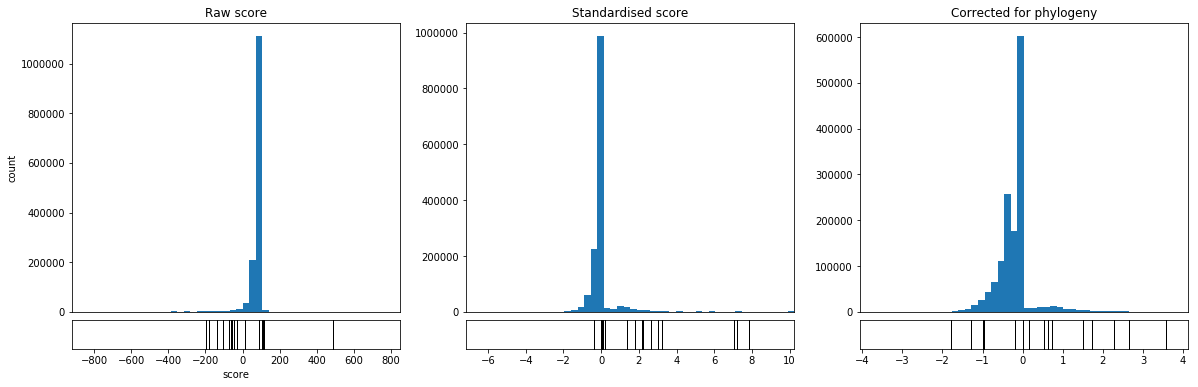

In [207]:
fig = plt.figure(figsize=(20, 6))

filename = '20200402_graph_iokr_paired_data_crusemann'

ax_min = min([x[0] for x in scores_all])
#ax_min = -0.05
ax_max = max([x[0] for x in scores_all])
#ax_max = 0.1

gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[20, 2], hspace=0.05)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])

ax1.set_title('Raw score')

ax1.hist([x[0] for x in scores_all], bins=50, range=[ax_min, ax_max])

ax2.plot([x[0] for x in scores_valid], [5000]*len([x[0] for x in scores_valid]), '|', color='k', markersize=50)
ax1.set_xlim([ax_min, ax_max])
ax2.set_xlim([ax_min, ax_max])
ax1.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel('count')
ax2.set_xlabel('score')



ax_min = min([x[1] for x in scores_all])
#ax_min = -0.05
ax_max = max([x[1] for x in scores_all])
#ax_max = 0.1

ax3 = plt.subplot(gs[0, 1])
ax4 = plt.subplot(gs[1, 1])

ax3.set_title('Standardised score')

ax3.hist([x[1] for x in scores_all], bins=50, range=[ax_min, ax_max])

ax4.plot([x[1] for x in scores_valid], [5000]*len([x[0] for x in scores_valid]), '|', color='k', markersize=50)
ax3.set_xlim([ax_min, ax_max])
ax4.set_xlim([ax_min, ax_max])
ax3.set_xticks([])
ax4.set_yticks([])



ax_min = min([x[2] for x in scores_all])
#ax_min = -0.05
ax_max = max([x[2] for x in scores_all])
#ax_max = 0.1

ax5 = plt.subplot(gs[0, 2])
ax6 = plt.subplot(gs[1, 2])

ax5.set_title('Corrected for phylogeny')

ax5.hist([x[2] for x in scores_all], bins=50, range=[ax_min, ax_max])

ax6.plot([x[2] for x in scores_valid], [5000]*len([x[0] for x in scores_valid]), '|', color='k', markersize=50)
ax5.set_xlim([ax_min, ax_max])
ax6.set_xlim([ax_min, ax_max])
ax5.set_xticks([])
ax6.set_yticks([])



plt.tight_layout()

plt.savefig('fig_phylo_verified.pdf')


In [253]:
# scores_all, scores_valid, gcf_scores_valid
# (raw, std, corr) or (gcf, raw, std, corr)

[(88, 1.6690459207927597, 0.7687061147858116),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (-13, -0.45210792592497717, -0.8528260089117418),
 (-134, -1.8613120187515835, -2.065029707929989),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (-375, -2.0056919296220217, -1.0932610110320882),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (-153, -0.04229155952818319, -0.42114708222291064),
 (-188, 0.02489339411993074, -0.08674473882940592),
 (78, 6

In [280]:
[x[0] for x in gcf_scores_valid]
sorted_std_scores = [x[1] for x in scores_all]
sorted_std_scores.sort(reverse=True)

sorted_corr_scores = [x[2] for x in scores_all]
sorted_corr_scores.sort(reverse=True)

verified_gcf_mf_links
for g in gcf_scores_valid:
    gcf, raw_score, std_score, corr_score = g
    for mibig_id, (link_gcf, link_mf) in zip (verified_gcf_mf_links_labels, verified_gcf_mf_links):
        if link_gcf == gcf:
            std_idx = sorted_std_scores.index(std_score)
            corr_idx = sorted_corr_scores.index(corr_score)
            delta = 'down' if corr_idx > std_idx else 'up'
            print("& {} & {} & {} & {:.04f} \\\\".format(mibig_id, std_idx, corr_idx, (std_idx - corr_idx) / std_idx))
            break

& BGC0000137 & 108063 & 1354052 & -11.5302 \\
& BGC0000137 & 105046 & 1357570 & -11.9236 \\
& BGC0000137 & 21594 & 88610 & -3.1035 \\
& BGC0000137 & 1240045 & 1402964 & -0.1314 \\
& BGC0000137 & 28765 & 14965 & 0.4797 \\
& BGC0000137 & 15879 & 10275 & 0.3529 \\
& BGC0000333 & 3216 & 2793 & 0.1315 \\
& BGC0001228 & 275167 & 263920 & 0.0409 \\
& BGC0000827 & 3789 & 885 & 0.7664 \\
& BGC0001830 & 1543 & 5056 & -2.2767 \\
& BGC0000137 & 52362 & 698671 & -12.3431 \\
& BGC0000137 & 107105 & 1390611 & -11.9836 \\
& BGC0000137 & 39428 & 53325 & -0.3525 \\
& BGC0000137 & 28971 & 59940 & -1.0690 \\
& BGC0000241 & 14676 & 66419 & -3.5257 \\


In [205]:
# gcf, raw, std, phyl
raw_score_ids = []
std_score_ids = []
phyl_score_ids = []

for gcf, raw, std, phyl in gcf_scores_valid:
    for label_idx, (bgc, mf) in enumerate(verified_bgc_mf_links):
        if bgc.id in [x.id for x in gcf.bgcs]:
            mibig_id = verified_bgc_mf_links_labels[label_idx]
            # print(bgc, raw, std, phyl)
            # print(kkb_bgc_hits[bgc])
            # print(mibig_id, raw, std, phyl)
            raw_score_ids.append((mibig_id, raw))
            std_score_ids.append((mibig_id, std))
            phyl_score_ids.append((mibig_id, phyl))
    
raw_score_ids.sort(key=lambda x:x[1], reverse=True)
std_score_ids.sort(key=lambda x:x[1], reverse=True)
phyl_score_ids.sort(key=lambda x:x[1], reverse=True)

for a, b, c in zip(raw_score_ids, std_score_ids, phyl_score_ids):
    #print(a + b + c)
    #print("{} & {} & {} & {} & {} & {} \\".format(list(a + b + c)))
    print("{} & {} & {} & {:.04f} & {} & {:.04f} \\\\".format(*(a + b + c)))
            
    #print(gcf)

BGC0000827 & 486 & BGC0001830 & 7.8598 & BGC0000827 & 3.5736 \\
BGC0000333 & 114 & BGC0000333 & 7.2111 & BGC0000333 & 2.6458 \\
BGC0001830 & 111 & BGC0000827 & 7.0682 & BGC0001830 & 2.2657 \\
BGC0001228 & 105 & BGC0000241 & 3.2167 & BGC0000137 & 1.7363 \\
BGC0000241 & 91 & BGC0000137 & 3.0407 & BGC0000137 & 1.7363 \\
BGC0000137 & 12 & BGC0000137 & 3.0407 & BGC0000137 & 1.5152 \\
BGC0000137 & 12 & BGC0000137 & 2.6653 & BGC0000137 & 1.5152 \\
BGC0000137 & -28 & BGC0000137 & 2.6653 & BGC0000137 & 0.7280 \\
BGC0000137 & -28 & BGC0000137 & 2.2103 & BGC0000137 & 0.7280 \\
BGC0000137 & -45 & BGC0000137 & 2.2103 & BGC0000137 & 0.6217 \\
BGC0000137 & -45 & BGC0000137 & 2.1581 & BGC0000137 & 0.6217 \\
BGC0000137 & -56 & BGC0000137 & 2.1581 & BGC0000241 & 0.5345 \\
BGC0000137 & -56 & BGC0000137 & 1.8053 & BGC0000137 & 0.1564 \\
BGC0000137 & -63 & BGC0000137 & 1.8053 & BGC0000137 & 0.1564 \\
BGC0000137 & -63 & BGC0000137 & 1.3776 & BGC0001228 & 0.0000 \\
BGC0000137 & -71 & BGC0000137 & 1.3776 & BG

In [215]:
percentile = numpy.percentile([x[0] for x in scores_all], 95)
v1 = len([x[0] for x in scores_valid if x[0] > percentile]) / len([x[0] for x in scores_all if x[0] > percentile])

percentile = numpy.percentile([x[1] for x in scores_all], 95)
v2 = len([x[1] for x in scores_valid if x[1] > percentile]) / len([x[1] for x in scores_all if x[1] > percentile])

percentile = numpy.percentile([x[2] for x in scores_all], 95)
v3 = len([x[2] for x in scores_valid if x[2] > percentile]) / len([x[2] for x in scores_all if x[2] > percentile])

print('raw score', v1)
print('std score', v2)
print('phyl score', v3)

raw score 8.48992528865746e-05
std score 0.00014238118290286757
phyl score 0.00011391143386017371


In [182]:
len([x[2] for x in scores_valid if x[2] > numpy.percentile([x[2] for x in scores_all], 95)])

8

In [183]:
len([x[1] for x in scores_valid if x[1] > numpy.percentile([x[1] for x in scores_all], 95)])

10

In [169]:
scores_all

[(88, 1.6690459207927597, 0.7687061147858116),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (-13, -0.45210792592497717, -0.8528260089117418),
 (-134, -1.8613120187515835, -2.065029707929989),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (-375, -2.0056919296220217, -1.0932610110320882),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (78, 6.758531445429812e-08, 3.725290298461914e-08),
 (-153, -0.04229155952818319, -0.42114708222291064),
 (-188, 0.02489339411993074, -0.08674473882940592),
 (78, 6

In [232]:
import matplotlib.patches as mpatches



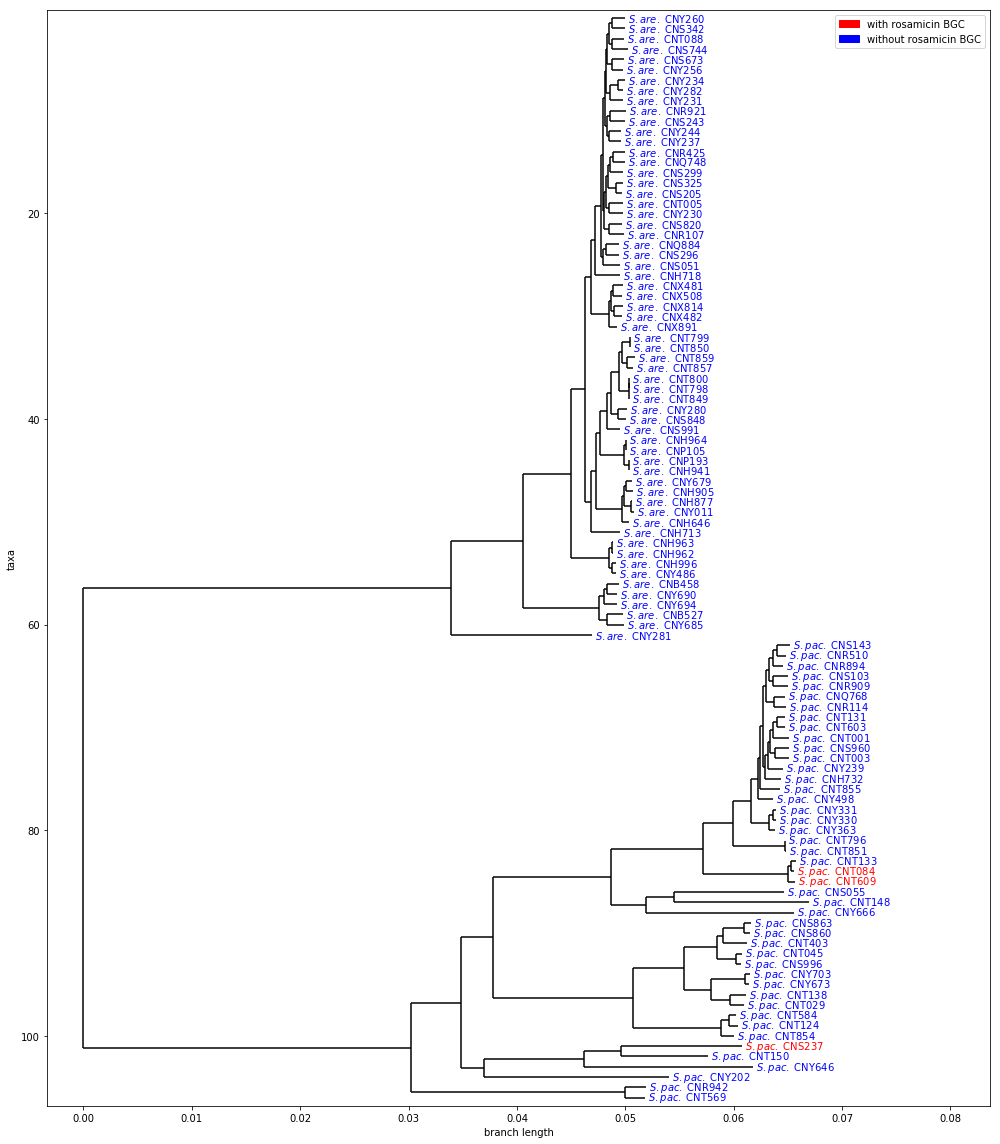

In [237]:
# staurosporine - BGC0000827 - polyphyletic - 
# rosamicin - BGC0001830 - monophyletic?

mibig_id = "BGC0001830"
gcf_mf_index = verified_gcf_mf_links_labels.index(mibig_id)
gcf, mf = verified_gcf_mf_links[gcf_mf_index]

gcf_strain_list = [x.id for x in gcf.strains]

salinispora_tree_copy = copy.deepcopy(salinispora_tree)
tree_colors = {}
for n in salinispora_tree_copy.get_terminals():
    if n.name in sal_pac:
        new_name = '$S.pac.$ ' + n.name
    elif n.name in sal_are:
        new_name = '$S.are.$ ' + n.name
    if n.name in gcf_strain_list:
        tree_colors[new_name] = 'r'
    else:
        tree_colors[new_name] = 'b'
    n.name = new_name

blue_patch = mpatches.Patch(color='blue', label='without rosamicin BGC')
red_patch = mpatches.Patch(color='red', label='with rosamicin BGC')

f = plt.figure(figsize=(14, 16))
ax = plt.gca()
ax.legend(handles=[red_patch, blue_patch])
Phylo.draw(salinispora_tree_copy, show_confidence=False, axes=ax, label_colors=tree_colors, do_show=False)

plt.tight_layout()


In [289]:
score_cutoff = 0.85

def get_kkb_gcf(bgc_list, mibig_id, threshold=0):
    gcf = nplinker.GCF(id=-1, gcf_id='GCF:'+mibig_id, product_type=None)
    for bgc in bgc_list:
        if bgc in kkb_bgc_hits:
            kkb_hits = kkb_bgc_hits[bgc]
            for mibig_hit_id, mibig_hit_score in kkb_hits:  # only use top hit
                if mibig_hit_id == mibig_id and mibig_hit_score > threshold:
                    gcf.add_bgc(bgc)
    return gcf
                
def get_kkb_gcf_and_mf(mibig_id, threshold=score_cutoff):
    gcf = get_kkb_gcf(npl.bgcs, mibig_id, threshold=threshold)
    link_index = verified_bgc_mf_links_labels.index(mibig_id)
    mf = verified_bgc_mf_links[link_index][1]
    return gcf, mf

In [291]:
get_kkb_gcf_and_mf('BGC0000333', 10000)

(GCF(id=-1, class=None, gcf_id=GCF:BGC0000333, strains=24),
 <nplinker.metabolomics.MolecularFamily at 0x7fddf4648940>)

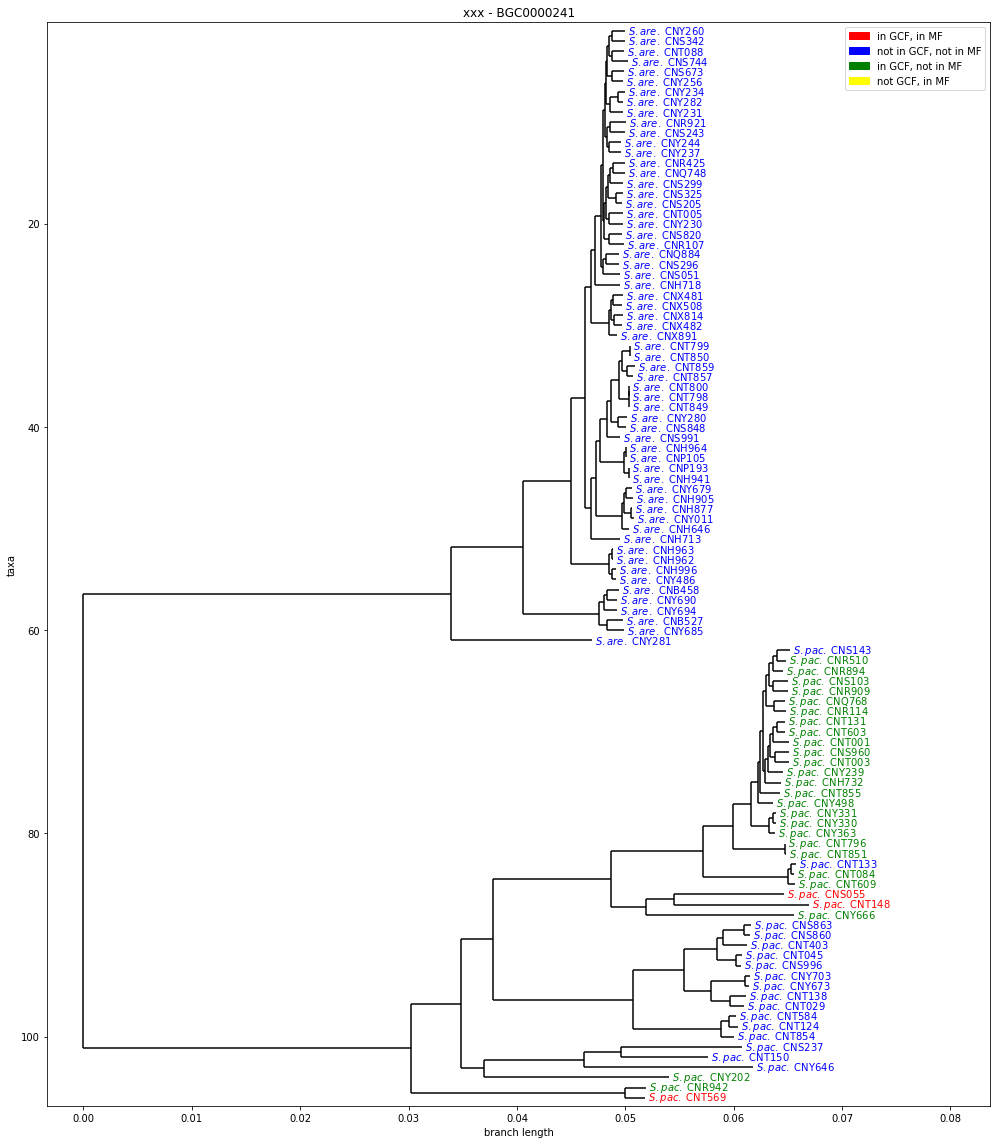

In [293]:
# staurosporine - BGC0000827 - polyphyletic - 
# rosamicin - BGC0001830 - monophyletic?

# up
#metabolite_name = "xxx"
#mibig_id = "BGC0000333"
#metabolite_name = "xxx"
#mibig_id = "BGC0000827"


# down
#metabolite_name = "rosamicin"
#mibig_id = "BGC0001830"
metabolite_name = "xxx"
mibig_id = "BGC0000241"

#metabolite_name = "staurosporine"
#mibig_id = "BGC0000827"
gcf_mf_index = verified_gcf_mf_links_labels.index(mibig_id)
gcf, mf = verified_gcf_mf_links[gcf_mf_index]

gcf_strain_list = [x.id for x in gcf.strains]
mf_strain_list = [x.id for x in mf.strains]

salinispora_tree_copy = copy.deepcopy(salinispora_tree)
tree_colors = {}
for n in salinispora_tree_copy.get_terminals():
    if n.name in sal_pac:
        new_name = '$S.pac.$ ' + n.name
    elif n.name in sal_are:
        new_name = '$S.are.$ ' + n.name
    if n.name in gcf_strain_list:
        if n.name in mf_strain_list:
            node_color = 'r'
        else:
            node_color = 'g'
    else:
        if n.name in mf_strain_list:
            node_color = 'y'
        else:
            node_color = 'b'
    tree_colors[new_name] = node_color
    n.name = new_name

blue_patch = mpatches.Patch(color='blue', label='not in GCF, not in MF')
red_patch = mpatches.Patch(color='red', label='in GCF, in MF')
yellow_patch = mpatches.Patch(color='yellow', label='not GCF, in MF')
green_patch = mpatches.Patch(color='green', label='in GCF, not in MF')

f = plt.figure(figsize=(14, 16))
ax = plt.gca()
ax.set_title("{} - {}".format(metabolite_name, mibig_id))
ax.legend(handles=[red_patch, blue_patch, green_patch, yellow_patch])
Phylo.draw(salinispora_tree_copy, show_confidence=False, axes=ax, label_colors=tree_colors, do_show=False)

plt.tight_layout()

In [363]:
Phylo.draw_ascii(salinispora_tree)

                                                 , CNY260
                                                ,|
                                                || CNS342
                                                |
                                                |, CNT088
                                                ||
                                                || CNS744
                                                |
                                                |, CNS673
                                                ||
                                                || CNY256
                                                |
                                                |, CNY234
                                                ,|
                                                || CNY282
                                                |
                                                |_ CNY231
                                                |
                        

In [395]:
salinispora_tree.get_terminals()

[Clade(branch_length=0.00117788, name='CNY260'),
 Clade(branch_length=0.00121814, name='CNS342'),
 Clade(branch_length=0.0011035, name='CNT088'),
 Clade(branch_length=0.00148481, name='CNS744'),
 Clade(branch_length=0.00113849, name='CNS673'),
 Clade(branch_length=0.00101789, name='CNY256'),
 Clade(branch_length=0.000606233, name='CNY234'),
 Clade(branch_length=0.000397797, name='CNY282'),
 Clade(branch_length=0.00121496, name='CNY231'),
 Clade(branch_length=0.00143605, name='CNR921'),
 Clade(branch_length=0.00133072, name='CNS243'),
 Clade(branch_length=0.00114032, name='CNY244'),
 Clade(branch_length=0.00113536, name='CNY237'),
 Clade(branch_length=0.00115106, name='CNR425'),
 Clade(branch_length=0.00113622, name='CNQ748'),
 Clade(branch_length=0.00119995, name='CNS299'),
 Clade(branch_length=0.000661826, name='CNS325'),
 Clade(branch_length=0.000586185, name='CNS205'),
 Clade(branch_length=0.00125853, name='CNT005'),
 Clade(branch_length=0.00128645, name='CNY230'),
 Clade(branch_len

In [285]:
print(dir(tree))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_filter_search', 'as_phyloxml', 'clade', 'collapse', 'collapse_all', 'common_ancestor', 'count_terminals', 'depths', 'distance', 'find_any', 'find_clades', 'find_elements', 'format', 'from_clade', 'get_nonterminals', 'get_path', 'get_terminals', 'id', 'is_bifurcating', 'is_monophyletic', 'is_parent_of', 'is_preterminal', 'is_terminal', 'ladderize', 'name', 'prune', 'randomized', 'root', 'root_at_midpoint', 'root_with_outgroup', 'rooted', 'split', 'total_branch_length', 'trace', 'weight']


In [250]:
tree = Phylo.read(io.StringIO("(A, (B, C), (D, E))"), "newick")

In [251]:
leaf_nodes = [t for t in tree.find_clades() if t.name != None]


In [252]:
Phylo.draw_ascii(tree)

  ____________________________________ A
 |
 |                                     _____________________________________ B
_|____________________________________|
 |                                    |_____________________________________ C
 |
 |                                     _____________________________________ D
 |____________________________________|
                                      |_____________________________________ E



In [253]:
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order="level"):
        for child in clade:
            parents[child] = clade
    return parents

parents = all_parents(tree)
clade = list(tree.find_clades('B'))[0]
parent = parents[clade]
parent.name = 'target'

print(list(tree.find_clades('target')))

clade2 = list(tree.find_clades('target'))[0]
clade2.clades = []

Phylo.draw_ascii(tree)


[Clade(name='target')]
  __________________________________ A
 |
_|__________________________________ target
 |
 |                                   ___________________________________ D
 |__________________________________|
                                    |___________________________________ E



In [249]:
print(clade)
print(dir(clade))
print(clade2)
print(clade2.is_terminal())
print(clade.clades)
clade2.clades=[]
print(clade2.is_terminal())

B
['__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_color', '_filter_search', '_get_color', '_set_color', 'branch_length', 'clades', 'collapse', 'collapse_all', 'color', 'comment', 'common_ancestor', 'confidence', 'count_terminals', 'depths', 'distance', 'find_any', 'find_clades', 'find_elements', 'get_nonterminals', 'get_path', 'get_terminals', 'is_bifurcating', 'is_monophyletic', 'is_parent_of', 'is_preterminal', 'is_terminal', 'ladderize', 'name', 'prune', 'root', 'split', 'total_branch_length', 'trace', 'width']
target
True
[]
True


In [231]:
clade2.clades
clade2.name
for x in clade2.clades:
    tree.collapse(x)
tree.collapse(clade2)

TypeError: unsupported operand type(s) for +=: 'NoneType' and 'int'

In [232]:
Phylo.draw_ascii(tree)

  _____________________________________ A
_|
 |                                      _____________________________________ D
 |_____________________________________|
                                       |_____________________________________ E



In [190]:
parents = all_parents(tree)

In [191]:
clade = list(tree.find_clades('B'))[0]

In [192]:
parent = parents[clade]

In [194]:
Phylo.draw_ascii(parent)

  ____________________________________________________________________________ B
_|
 |____________________________________________________________________________ C



In [208]:
dir(clade2[0])

['__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_color',
 '_filter_search',
 '_get_color',
 '_set_color',
 'branch_length',
 'clades',
 'collapse',
 'collapse_all',
 'color',
 'comment',
 'common_ancestor',
 'confidence',
 'count_terminals',
 'depths',
 'distance',
 'find_any',
 'find_clades',
 'find_elements',
 'get_nonterminals',
 'get_path',
 'get_terminals',
 'is_bifurcating',
 'is_monophyletic',
 'is_parent_of',
 'is_preterminal',
 'is_terminal',
 'ladderize',
 'name',
 'prune',
 'root',
 'split',
 'total_branch_length',
 'trace',
 'width']